In [6]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore
# # step one, dannce alignment
import os
import sys
sys.path.append(os.path.abspath('../..'))


def load_filtered_data_from_h5(h5_file_path):
    """
    Loads the 'filtered_data' group from an HDF5 file into a Pandas DataFrame.
    """
    with h5py.File(h5_file_path, "r") as hf:
        # Access the group where the DataFrame columns were saved
        grp = hf["filtered_data"]
        
        # Each dataset in 'grp' is a column; read them into a dict of numpy arrays
        data_dict = {}
        for col_name in grp.keys():
            # Read dataset
            col_data = grp[col_name][:]
            
            # If it's a string dataset, h5py might already give you Python strings,
            # but just to be safe, handle bytes if encountered
            if col_data.dtype.kind in ["S", "O"] or isinstance(col_data.flatten()[0], bytes):
                col_data = [elem.decode("utf-8") if isinstance(elem, bytes) else elem 
                            for elem in col_data]
            
            data_dict[col_name] = col_data
        
    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data_dict)
    return df

# def plot_cluster_timeline_on_axes(ax, df, time_index=None, behavior_labels=None, xlim=None):
#     """
#     Plots cluster timeline on a provided Axes object (ax),
#     aligned with time_index if given, and colored by behavior labels if provided.
    
#     Parameters:
#         ax: Matplotlib Axes object.
#         df: DataFrame containing 'Prediction_path', 'Cluster', and 'frame' or 'n_frames'.
#         time_index: (Optional) Time index to map frames to timestamps.
#         behavior_labels: (Optional) Dictionary mapping clusters to behaviors (e.g., {1: 'Grooming'}).
#         xlim: (Optional) Tuple specifying x-axis limits (e.g., (0, 100)).
#     """
#     unique_paths = df['Prediction_path'].unique()
#     cmap = plt.cm.tab10
#     cluster_colors = {}

#     if behavior_labels:
#         unique_behaviors = set(behavior_labels.values())
#         behavior_colors = {behavior: cmap(i) for i, behavior in enumerate(unique_behaviors)}
#         for cluster, behavior in behavior_labels.items():
#             cluster_colors[cluster] = behavior_colors[behavior]

#     for path in unique_paths:
#         path_data = df[df['Prediction_path'] == path]
#         frames = path_data['frame'].values if 'frame' in path_data.columns else np.arange(len(path_data))
#         clusters = path_data['Cluster'].values
        
#         if time_index is not None:
#             frames = frames.astype(int)
#             valid_mask = (frames >= 0) & (frames < len(time_index))
#             frames_valid = frames[valid_mask]
#             clusters_valid = clusters[valid_mask]
#             plot_x = time_index[frames_valid]
#         else:
#             plot_x = frames

#         if behavior_labels:
#             colors = [cluster_colors.get(cluster, 'gray') for cluster in clusters_valid]
#         else:
#             norm = plt.Normalize(vmin=min(clusters), vmax=max(clusters))
#             colors = plt.cm.tab10(norm(clusters))

#         ax.scatter(plot_x, np.zeros_like(plot_x), c=colors, marker='|', s=200, label=path)

#     if xlim:
#         ax.set_xlim(xlim)

def plot_cluster_timeline_on_axes(ax, df, time_index=None, behavior_labels=None):
    """
    Plots cluster timeline on a provided Axes object (ax),
    aligned with time_index if given, and colored by behavior labels if provided.
    
    Parameters:
        ax: Matplotlib Axes object.
        df: DataFrame containing 'Prediction_path', 'Cluster', and 'frame' or 'n_frames'.
        time_index: (Optional) Time index to map frames to timestamps.
        behavior_labels: (Optional) Dictionary mapping clusters to behaviors (e.g., {1: 'Grooming'}).
    """
    unique_paths = df['Prediction_path'].unique()

    # Default colormap
    cmap = plt.cm.tab10
    cluster_colors = {}
    
    # Prepare behavior-specific colors if labels are provided
    if behavior_labels:
        unique_behaviors = set(behavior_labels.values())
        behavior_colors = {behavior: cmap(i) for i, behavior in enumerate(unique_behaviors)}
        for cluster, behavior in behavior_labels.items():
            cluster_colors[cluster] = behavior_colors[behavior]

    for path in unique_paths:
        path_data = df[df['Prediction_path'] == path]
        
        # Identify frames
        if 'frame' in path_data.columns:
            frames = path_data['frame'].values
        elif 'n_frames' in path_data.columns:
            frames = path_data['n_frames'].values
        else:
            frames = np.arange(len(path_data))
        
        # Get clusters
        if 'Cluster' not in path_data.columns:
            print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
            continue
        clusters = path_data['Cluster'].values
        
        # Convert string clusters to numeric if needed
        if not np.issubdtype(clusters.dtype, np.number):
            unique_str_clusters = np.unique(clusters)
            cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
            clusters_numeric = [cluster_idx_map[c] for c in clusters]
            clusters = np.array(clusters_numeric)
        
        # Map frames -> timestamps if time_index is provided
        if time_index is not None:
            frames = frames.astype(int)
            valid_mask = (frames >= 0) & (frames < len(time_index))
            frames_valid = frames[valid_mask]
            clusters_valid = clusters[valid_mask]
            plot_x = time_index[frames_valid]  # Actual timestamps
        else:
            frames_valid = frames
            clusters_valid = clusters
            plot_x = frames_valid
        
        # Map clusters to colors
        if behavior_labels:
            colors = [cluster_colors.get(cluster, 'gray') for cluster in clusters_valid]
        else:
            unique_clusters = np.unique(clusters_valid)
            norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
            colors = plt.cm.tab10(norm(clusters_valid))
        
        # Plot on the provided Axes
        ax.scatter(plot_x, np.zeros_like(plot_x), 
                   c=colors, marker='|', s=200, label=path)
    
    # Cosmetic fixes
    ax.set_title("Cluster Timeline by Behavior")
    # ax.set_yticks([])
    if behavior_labels:
        ax.legend(handles=[plt.Line2D([0], [0], color=color, marker='|', 
                                       markersize=10, label=behavior, linestyle='None') 
                           for behavior, color in behavior_colors.items()],
                  loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust as needed

# def plot_cluster_timeline_on_axes(ax, df, time_index=None, behavior_labels=None):
#     """
#     Plots cluster timeline on a provided Axes object (ax),
#     aligned with time_index if given, and colored by behavior labels if provided.
    
#     Parameters:
#         ax: Matplotlib Axes object.
#         df: DataFrame containing 'Prediction_path', 'Cluster', and 'frame' or 'n_frames'.
#         time_index: (Optional) Time index to map frames to timestamps.
#         behavior_labels: (Optional) Dictionary mapping clusters to behaviors (e.g., {1: 'Grooming'}).
#     """
#     unique_paths = df['Prediction_path'].unique()

#     # Default colormap
#     cmap = plt.cm.tab10
#     cluster_colors = {}
    
#     # Prepare behavior-specific colors if labels are provided
#     if behavior_labels:
#         unique_behaviors = set(behavior_labels.values())
#         behavior_colors = {behavior: cmap(i) for i, behavior in enumerate(unique_behaviors)}
#         for cluster, behavior in behavior_labels.items():
#             cluster_colors[cluster] = behavior_colors[behavior]

#     for path in unique_paths:
#         path_data = df[df['Prediction_path'] == path]
        
#         # Identify frames
#         if 'frame' in path_data.columns:
#             frames = path_data['frame'].values
#         elif 'n_frames' in path_data.columns:
#             frames = path_data['n_frames'].values
#         else:
#             frames = np.arange(len(path_data))
        
#         # Get clusters
#         if 'Cluster' not in path_data.columns:
#             print(f"Warning: 'Cluster' column not found for path '{path}', skipping.")
#             continue
#         clusters = path_data['Cluster'].values
        
#         # Convert string clusters to numeric if needed
#         if not np.issubdtype(clusters.dtype, np.number):
#             unique_str_clusters = np.unique(clusters)
#             cluster_idx_map = {val: i for i, val in enumerate(unique_str_clusters)}
#             clusters_numeric = [cluster_idx_map[c] for c in clusters]
#             clusters = np.array(clusters_numeric)
        
#         # Map frames -> timestamps if time_index is provided
#         if time_index is not None:
#             frames = frames.astype(int)
#             valid_mask = (frames >= 0) & (frames < len(time_index))
#             frames_valid = frames[valid_mask]
#             clusters_valid = clusters[valid_mask]
#             plot_x = time_index[frames_valid]  # Actual timestamps
#         else:
#             frames_valid = frames
#             clusters_valid = clusters
#             plot_x = frames_valid
        
#         # Map clusters to colors
#         if behavior_labels:
#             colors = [cluster_colors.get(cluster, 'gray') for cluster in clusters_valid]
#         else:
#             unique_clusters = np.unique(clusters_valid)
#             norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
#             colors = plt.cm.tab10(norm(clusters_valid))
        
#         # Plot on the provided Axes
#         ax.scatter(plot_x, clusters_valid, 
#                    c=colors, marker='|', s=200, label=path, alpha=0.8)
    
#     # Cosmetic fixes to match isolated behaviors
#     ax.set_title("Cluster Timeline by Behavior", pad=10)
#     ax.set_yticks([])  # Remove y-axis ticks
#     ax.set_ylabel("")  # Remove y-axis label
#     ax.spines['left'].set_visible(False)  # Hide left spine
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.grid(False)  # Remove grid lines

#     # Optional legend for behaviors
#     if behavior_labels:
#         ax.legend(
#             handles=[plt.Line2D([0], [0], color=color, marker='|', 
#                                 markersize=10, label=behavior, linestyle='None') 
#                      for behavior, color in behavior_colors.items()],
#             loc='upper right', bbox_to_anchor=(1.2, 1.0))  # Adjust as needed

def plot_behavior_clusters(ax, df, behavior_name, behavior_labels, time_index=None, cluster_column='Cluster', frame_column='frame'):
    """
    Plots all clusters corresponding to a specific behavior on a given Axes object.
    
    Parameters:
        ax: Matplotlib Axes object.
        df: DataFrame containing cluster and frame information.
        behavior_name: The behavior to plot (e.g., 'Grooming').
        behavior_labels: Dictionary mapping clusters to behavior names.
        time_index: (Optional) Time index for mapping frames to timestamps.
        cluster_column: Name of the column containing cluster IDs.
        frame_column: Name of the column containing frame indices.
    """
    # Identify clusters corresponding to the behavior
    clusters = [cluster for cluster, behavior in behavior_labels.items() if behavior == behavior_name]
    
    # Filter DataFrame for the selected clusters
    behavior_data = df[df[cluster_column].isin(clusters)]
    
    if time_index is not None and frame_column in behavior_data.columns:
        # Map frames to actual time
        frames = behavior_data[frame_column].astype(int)
        valid_mask = (frames >= 0) & (frames < len(time_index))
        plot_x = time_index[frames[valid_mask]]
    else:
        plot_x = behavior_data[frame_column].values if frame_column in behavior_data.columns else np.arange(len(behavior_data))
    
    # Plot the behavior
    ax.vlines(plot_x, ymin=0, ymax=1, color='black', label=behavior_name)
    ax.set_title(f"Behavior: {behavior_name}")
    ax.set_ylabel("Activity")
    ax.set_yticks([])
    ax.legend(loc='upper right')

In [7]:
df_merged_with_dF_F

NameError: name 'df_merged_with_dF_F' is not defined

In [8]:
# -------------------------------------------------------------------
# 3) Example usage with filtered_df (loaded from HDF5)
#    You already have a function for that, e.g. load_filtered_data_from_h5
# -------------------------------------------------------------------
aligned_dappy_path = "/home/lq53/mir_repos/dappy_24_nov/byws_version/250116_wav_ffix_ang_pos/50_p/aligned_mir_walalala_filtered_data.h5"
# "/home/lq53/mir_repos/dappy_24_nov/byws_version/250109_opti/60_p/aligned_mir_walalala_filtered_data.h5"

filtered_df = load_filtered_data_from_h5(aligned_dappy_path)

rec_path = '/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_17_05'

hdf5_file_path = os.path.join(rec_path, 'MIR_Aligned/aligned_predictions_with_ca_and_dF_F.h5')

# Load the DataFrame from the HDF5 file
df_merged_with_dF_F = pd.read_hdf(hdf5_file_path, key='df')

# Assuming df_merged_with_dF_F is already loaded
# Extract columns that correspond to neurons
neuron_columns = [col for col in df_merged_with_dF_F.columns if col.startswith('dF_F_roi')]
neuron_activity = df_merged_with_dF_F[neuron_columns].values  # shape: (timepoints, neurons)

# Transpose to get shape: (neurons, timepoints)
neuron_activity = neuron_activity.T

# Step to drop low-variance neurons (reduce false positives)
neuron_variances = np.var(neuron_activity, axis=1)  # Variance for each neuron
threshold = np.percentile(neuron_variances, 5)      # Keep top 95% variance
high_variance_indices = neuron_variances > threshold  # Mask for neurons to keep

# Filter neuron activity and neuron column names
neuron_activity_filtered = neuron_activity[high_variance_indices, :]
filtered_neuron_columns = [col for i, col in enumerate(neuron_columns) if high_variance_indices[i]]


# Optional: Z-score normalization along each neuron's time course
neuron_activity_normalized = zscore(neuron_activity_filtered, axis=1)
# 'correlation' is often a good metric for neural activity, but you can try 'euclidean'.
# 'average' linkage is a common choice, but feel free to experiment (e.g., 'ward', 'complete').
# Perform hierarchical clustering on the filtered and normalized data
Z = linkage(neuron_activity_normalized, method='average', metric='correlation')

# Define behavior labels for clusters
# behavior_labels = {
#     1: 'Grooming', 4: 'Grooming', 7: 'Grooming', 23: 'Grooming',
#     2: 'Sniffing', 5: 'Sniffing', 10: 'Sniffing', 30: 'Walking'
# }
#the bad example
# behavior_labels = {
#     1: 'sniffing', 2: 'sniffing', 29: 'sniffing', 30: 'sniffing', 52: 'sniffing',
#     3: 'sniffing and walking', 4: 'sniffing and walking', 5: 'sniffing and walking',
#     6: 'sniffing and walking', 7: 'sniffing and walking', 8: 'sniffing and walking',
#     9: 'sniffing and walking', 11: 'sniffing and walking', 13: 'sniffing and walking',
#     14: 'sniffing and walking', 15: 'sniffing and walking', 17: 'sniffing and walking',
#     18: 'sniffing and walking', 19: 'sniffing and walking', 20: 'sniffing and walking',
#     21: 'sniffing and walking',
#     10: 'static', 69: 'static', 103: 'static', 127: 'static', 121: 'static',
#     104: 'grooming and walking',
#     72: 'grooming', 79: 'grooming', 80: 'grooming', 81: 'grooming', 92: 'grooming',
#     100: 'grooming', 111: 'grooming', 113: 'grooming',
#     82: 'edge peeking', 83: 'edge peeking',
#     89: 'rearing and walking'
# }

# # Add all remaining indices as 'sniffing and walking'
# all_indices = set(range(1, 130))  # Assuming the range of interest is from 1 to 129
# bad_indices = {16, 27, 39, 42, 60}
# defined_indices = set(behavior_labels.keys())

# # Find the remaining indices for 'sniffing and walking'
# remaining_indices = all_indices - bad_indices - defined_indices

# # Add them to the dictionary
# for idx in remaining_indices:
#     behavior_labels[idx] = 'sniffing and walking'

# # 250116 good one
# behavior_labels = {
#     50: 'slow groom', 16: 'slow groom', 38: 'slow groom', 39: 'slow groom', 42: 'slow groom', 44: 'slow groom',
#     59: 'slow walk', 26: 'slow walk', 29: 'slow walk', 30: 'slow walk', 47: 'slow walk',
#     51: 'slow',
#     64: 'grooming', 10: 'grooming', 12: 'grooming', 13: 'grooming', 14: 'grooming', 15: 'grooming', 18: 'grooming',
#     20: 'grooming', 21: 'grooming', 22: 'grooming', 23: 'grooming', 25: 'grooming', 31: 'grooming', 32: 'grooming',
#     34: 'grooming', 40: 'grooming',
#     52: 'sniff', 83: 'sniff', 84: 'sniff', 96: 'sniff', 98: 'sniff', 99: 'sniff', 103: 'sniff', 104: 'sniff',
#     111: 'sniff', 118: 'sniff', 119: 'sniff',
#     89: 'rearing', 17: 'rearing',
#     53: 'walk with head down', 54: 'walk with head down', 57: 'walk with head down', 58: 'walk with head down',
#     61: 'walk with head down', 63: 'walk with head down', 65: 'walk with head down', 71: 'walk with head down',
#     72: 'walk with head down', 74: 'walk with head down', 75: 'walk with head down', 76: 'walk with head down',
#     78: 'walk with head down', 85: 'walk with head down', 92: 'walk with head down', 93: 'walk with head down',
#     95: 'walk with head down', 96: 'walk with head down', 101: 'walk with head down', 110: 'walk with head down',
#     112: 'walk with head down', 113: 'walk with head down', 114: 'walk with head down', 115: 'walk with head down',
#     116: 'walk with head down', 12219: 'walk with head down', 37: 'walk with head down', 45: 'walk with head down',
#     46: 'walk with head down', 48: 'walk with head down',
#     24: 'sniff and walk', 27: 'sniff and walk', 28: 'sniff and walk', 33: 'sniff and walk', 36: 'sniff and walk',
#     41: 'sniff and walk', 43: 'sniff and walk', 49: 'sniff and walk', 55: 'sniff and walk', 56: 'sniff and walk',
#     66: 'sniff and walk', 67: 'sniff and walk', 68: 'sniff and walk', 73: 'sniff and walk', 79: 'sniff and walk',
#     81: 'sniff and walk', 82: 'sniff and walk', 87: 'sniff and walk', 97: 'sniff and walk', 100: 'sniff and walk',
#     107: 'sniff and walk', 108: 'sniff and walk', 114: 'sniff and walk',
#     60: 'static', 62: 'static', 70: 'static', 77: 'static', 80: 'static', 88: 'static', 90: 'static', 91: 'static',
#     102: 'static', 104: 'static', 105: 'static', 117: 'static', 121: 'static', 126: 'static', 127: 'static',
#     128: 'static', 129: 'static', 130: 'static', 131: 'static', 132: 'static', 133: 'static',
#     106: 'edge', 109: 'edge',
#     120: 'sniff down', 125: 'sniff down',
#     123: 'edge walk and sniff down', 124: 'edge walk and sniff down'
# }
#a simpler version of above.
behavior_labels = {
    50: 'grooming', 16: 'grooming', 38: 'grooming', 39: 'grooming', 42: 'grooming', 44: 'grooming',
    64: 'grooming', 10: 'grooming', 12: 'grooming', 13: 'grooming', 14: 'grooming', 15: 'grooming', 18: 'grooming',
    20: 'grooming', 21: 'grooming', 22: 'grooming', 23: 'grooming', 25: 'grooming', 31: 'grooming', 32: 'grooming',
    34: 'grooming', 40: 'grooming',
    52: 'sniff', 83: 'sniff', 84: 'sniff', 96: 'sniff', 98: 'sniff', 99: 'sniff', 103: 'sniff', 104: 'sniff',
    111: 'sniff', 118: 'sniff', 119: 'sniff', 120: 'sniff', 125: 'sniff',
    59: 'walking', 26: 'walking', 29: 'walking', 30: 'walking', 47: 'walking', 51: 'walking', 53: 'walking',
    54: 'walking', 57: 'walking', 58: 'walking', 61: 'walking', 63: 'walking', 65: 'walking', 71: 'walking',
    72: 'walking', 74: 'walking', 75: 'walking', 76: 'walking', 78: 'walking', 85: 'walking', 92: 'walking',
    93: 'walking', 95: 'walking', 96: 'walking', 101: 'walking', 110: 'walking', 112: 'walking', 113: 'walking',
    114: 'walking', 115: 'walking', 116: 'walking', 12219: 'walking', 37: 'walking', 45: 'walking', 46: 'walking',
    48: 'walking', 24: 'walking', 27: 'walking', 28: 'walking', 33: 'walking', 36: 'walking', 41: 'walking',
    43: 'walking', 49: 'walking', 55: 'walking', 56: 'walking', 66: 'walking', 67: 'walking', 68: 'walking',
    73: 'walking', 79: 'walking', 81: 'walking', 82: 'walking', 87: 'walking', 97: 'walking', 100: 'walking',
    107: 'walking', 108: 'walking',
    60: 'static', 62: 'static', 70: 'static', 77: 'static', 80: 'static', 88: 'static', 90: 'static', 91: 'static',
    102: 'static', 104: 'static', 105: 'static', 117: 'static', 121: 'static', 126: 'static', 127: 'static',
    128: 'static', 129: 'static', 130: 'static', 131: 'static', 132: 'static', 133: 'static',
    106: 'edge interaction', 109: 'edge interaction', 123: 'edge interaction', 124: 'edge interaction',
    89: 'rearing', 17: 'rearing'
}


df_new = df_merged_with_dF_F.copy()
df_new = df_new.reset_index()
time = df_new['timestamp_ms_mini']

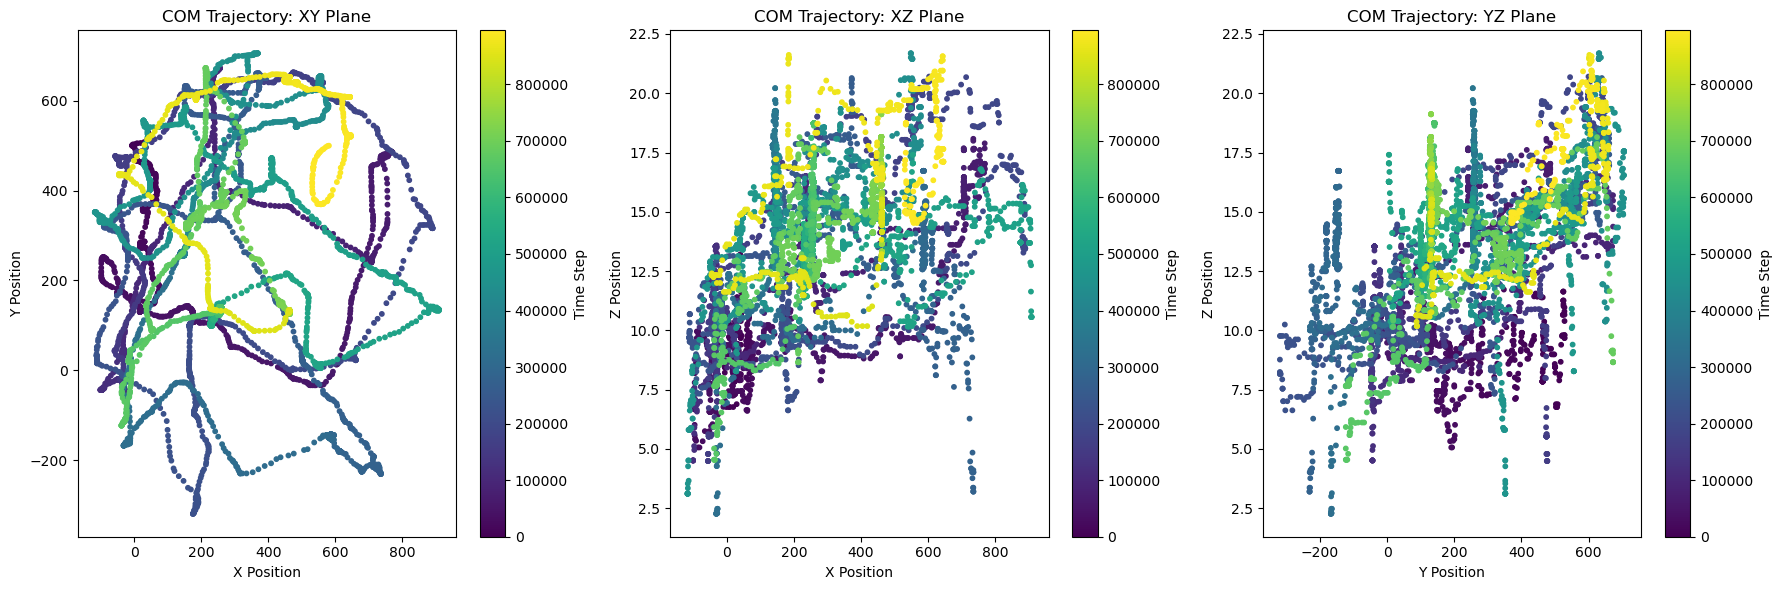

In [53]:
# from utlis.vis_valid_utlis.com_trag_updated import plot_3d_trajectory_com
import scipy.io as sio



# df_new = df_merged_with_dF_F.copy()
# time = df_new.index

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# XY Plane
scatter_xy = ax[0].scatter(df_new['com_x'], df_new['com_y'], c=time, cmap='viridis', s=10)
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')
ax[0].set_title('COM Trajectory: XY Plane')
fig.colorbar(scatter_xy, ax=ax[0], label='Time Step')

# XZ Plane
scatter_xz = ax[1].scatter(df_new['com_x'], df_new['com_z'], c=time, cmap='viridis', s=10)
ax[1].set_xlabel('X Position')
ax[1].set_ylabel('Z Position')
ax[1].set_title('COM Trajectory: XZ Plane')
fig.colorbar(scatter_xz, ax=ax[1], label='Time Step')

# YZ Plane
scatter_yz = ax[2].scatter(df_new['com_y'], df_new['com_z'], c=time, cmap='viridis', s=10)
ax[2].set_xlabel('Y Position')
ax[2].set_ylabel('Z Position')
ax[2].set_title('COM Trajectory: YZ Plane')
fig.colorbar(scatter_yz, ax=ax[2], label='Time Step')

plt.tight_layout()
plt.show()



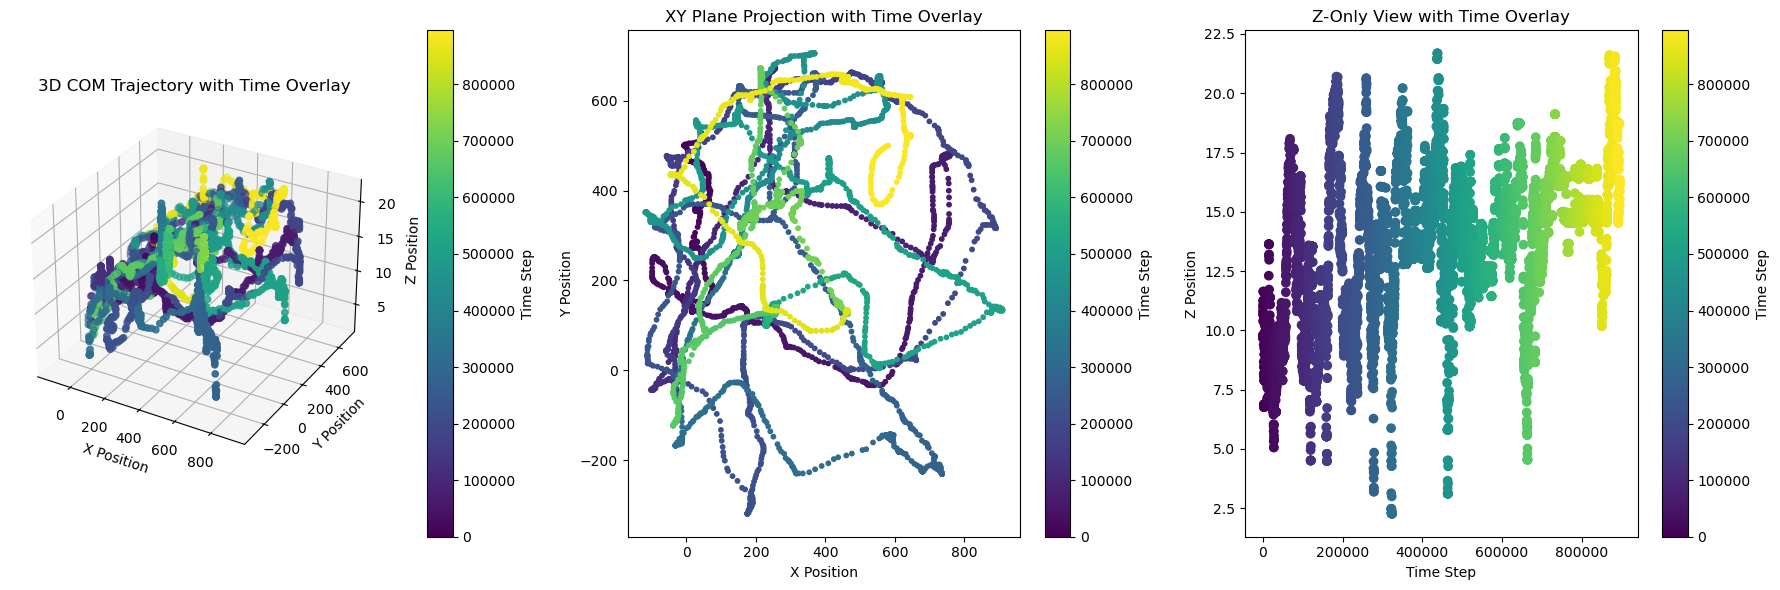

In [54]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18, 6))

# 3D Scatter Plot with Time Overlay
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(
    df_new['com_x'], df_new['com_y'], df_new['com_z'],
    c=df_new['timestamp_ms_mini'], cmap='viridis', marker='o'
)
ax1.set_title('3D COM Trajectory with Time Overlay')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_zlabel('Z Position')
cbar1 = fig.colorbar(scatter, ax=ax1, pad=0.1, label='Time Step')

# XY Plane Projection with Time Overlay
ax2 = fig.add_subplot(132)
scatter_xy = ax2.scatter(
    df_new['com_x'], df_new['com_y'],
    c=df_new['timestamp_ms_mini'], cmap='viridis', s=10
)
ax2.set_title('XY Plane Projection with Time Overlay')
ax2.set_xlabel('X Position')
ax2.set_ylabel('Y Position')
cbar2 = fig.colorbar(scatter_xy, ax=ax2, label='Time Step')

# Z-Only View with Time Overlay
ax3 = fig.add_subplot(133)
scatter_z = ax3.scatter(
    df_new['timestamp_ms_mini'], df_new['com_z'],
    c=df_new['timestamp_ms_mini'], cmap='viridis', marker='o'
)
ax3.set_title('Z-Only View with Time Overlay')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Z Position')
cbar3 = fig.colorbar(scatter_z, ax=ax3, label='Time Step')

plt.tight_layout()
plt.show()


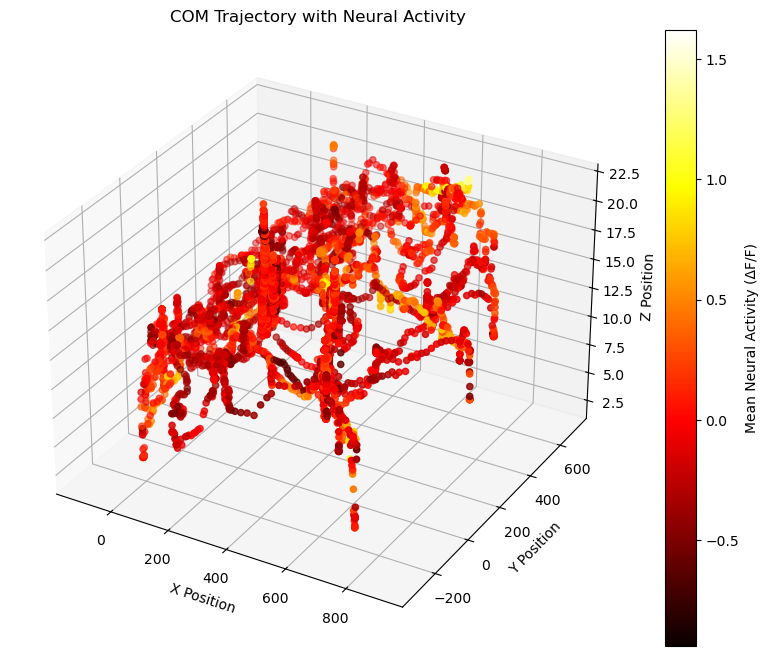

In [55]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the COM trajectory
scatter = ax.scatter(
    df_new['com_x'], df_new['com_y'], df_new['com_z'],
    c=np.mean(neuron_activity_normalized, axis=0), cmap='hot', marker='o'
)
ax.set_title('COM Trajectory with Neural Activity')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
fig.colorbar(scatter, ax=ax, label='Mean Neural Activity (ΔF/F)')
plt.show()


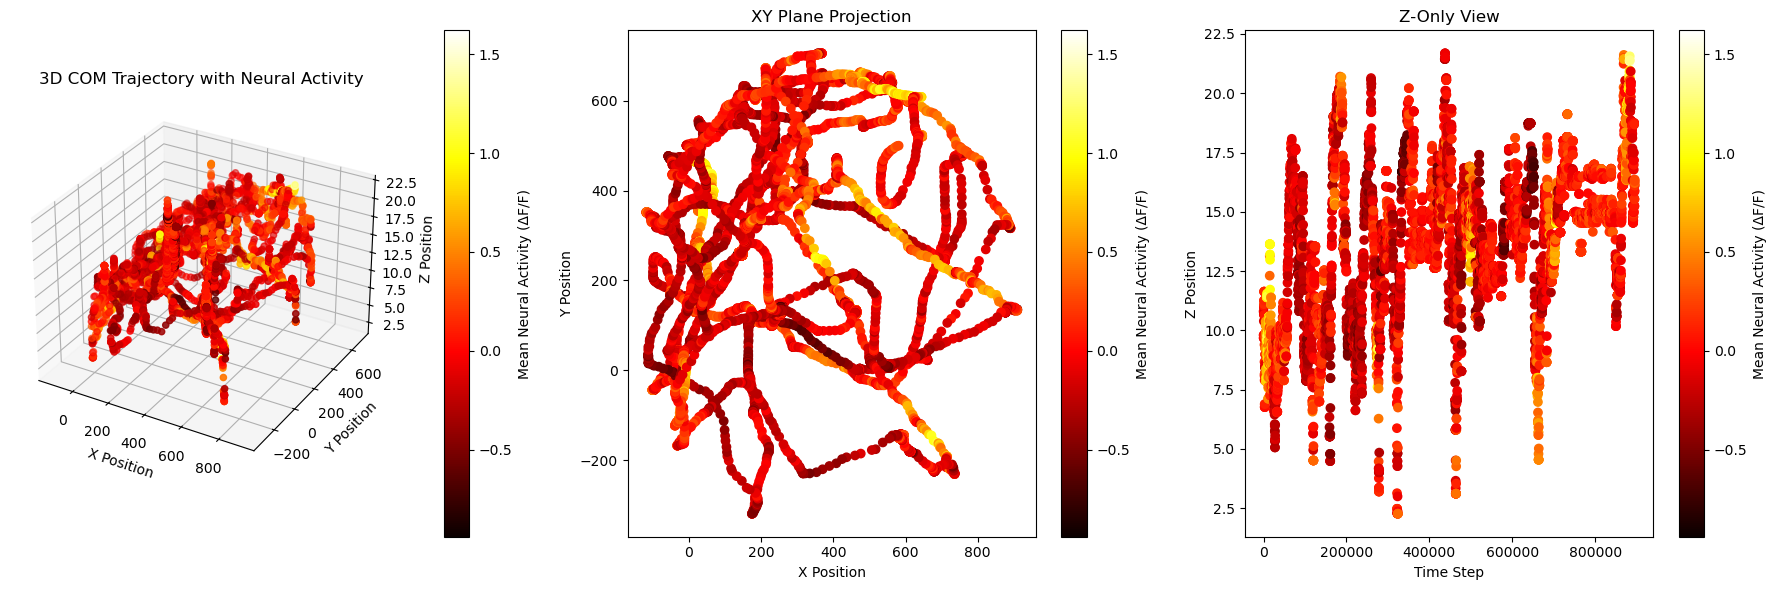

In [9]:
fig = plt.figure(figsize=(18, 6))
# df_new = df_new.reset_index()


# time = df_new['timestamp_ms_mini']
# 3D Scatter Plot
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(
    df_new['com_x'], df_new['com_y'], df_new['com_z'],
    c=np.mean(neuron_activity_normalized, axis=0), cmap='hot', marker='o'
)
ax1.set_title('3D COM Trajectory with Neural Activity')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_zlabel('Z Position')
cbar = fig.colorbar(scatter, ax=ax1, pad=0.1, label='Mean Neural Activity (ΔF/F)')

# XY Plane Projection
ax2 = fig.add_subplot(132)
scatter_xy = ax2.scatter(
    df_new['com_x'], df_new['com_y'],
    c=np.mean(neuron_activity_normalized, axis=0), cmap='hot', marker='o'
)
ax2.set_title('XY Plane Projection')
ax2.set_xlabel('X Position')
ax2.set_ylabel('Y Position')
fig.colorbar(scatter_xy, ax=ax2, label='Mean Neural Activity (ΔF/F)')

# Z-Only View
ax3 = fig.add_subplot(133)
scatter_z = ax3.scatter(
    time, df_new['com_z'],
    c=np.mean(neuron_activity_normalized, axis=0), cmap='hot', marker='o'
)
ax3.set_title('Z-Only View')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Z Position')
fig.colorbar(scatter_z, ax=ax3, label='Mean Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


Time steps with large Z-axis magnitude differences:
1579     2.650000
2772     4.652350
3218     5.400767
3485     5.849083
5155     8.652050
5179     8.692233
6772    11.365950
6787    11.391150
Name: timestamp_ms_mini, dtype: float64


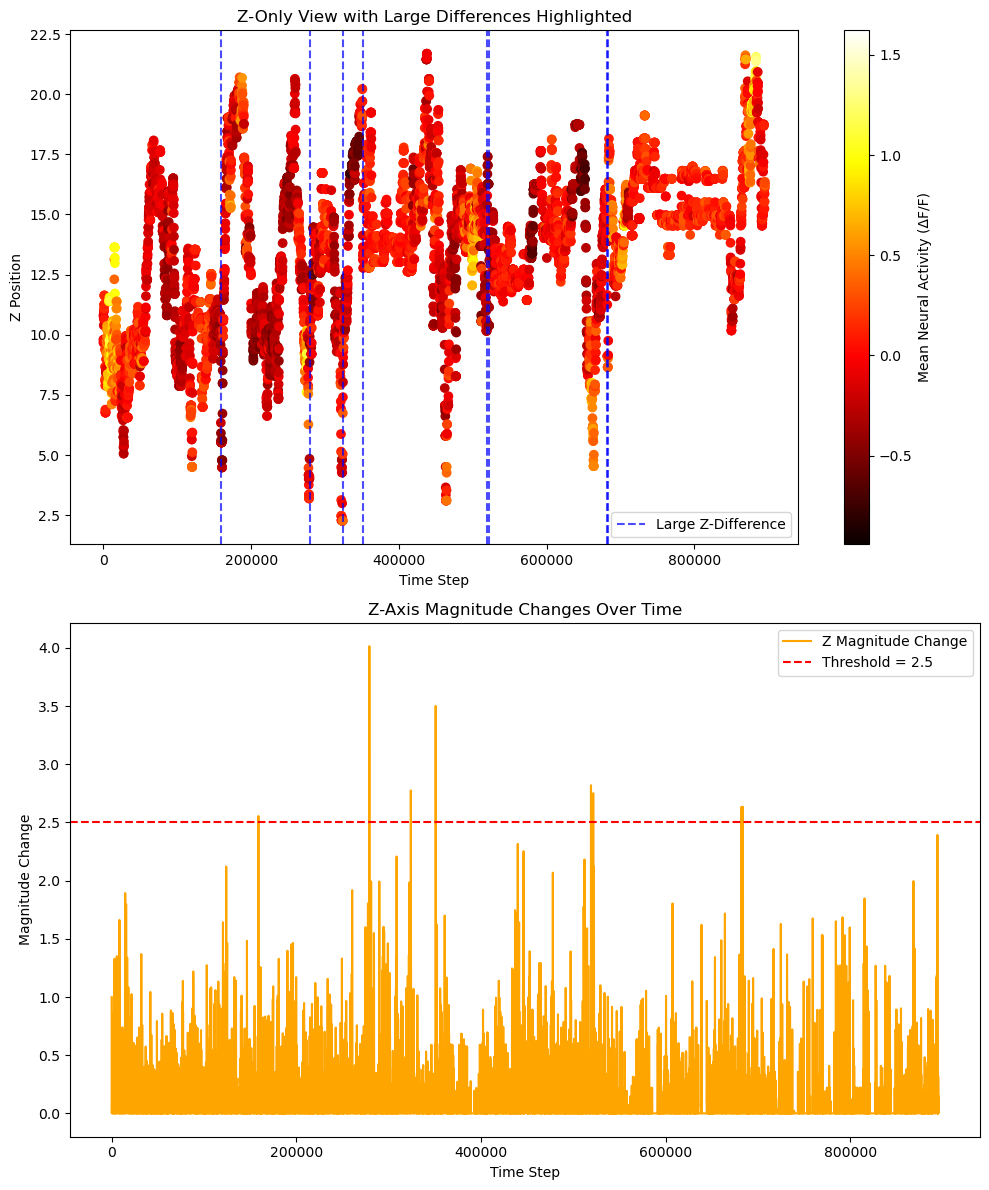

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the magnitude difference of the Z-axis
df_new['z_diff'] = df_new['com_z'].diff().abs()

# Define a threshold for large differences
threshold = 2.5  # Adjust this value as needed

# Find the time steps where the magnitude difference exceeds the threshold
large_dif_indices = df_new[df_new['z_diff'] > threshold].index
large_dif_times = df_new.loc[large_dif_indices, 'timestamp_ms_mini']

# Print the times when the magnitude difference is large
print("Time steps with large Z-axis magnitude differences:")
print(large_dif_times/60000)

# Visualize the Z-Only view with lines indicating large differences
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Z-Only View with Neural Activity
scatter_z = ax1.scatter(
    df_new['timestamp_ms_mini'], df_new['com_z'],
    c=np.mean(neuron_activity_normalized, axis=0), cmap='hot', marker='o'
)
ax1.set_title('Z-Only View with Large Differences Highlighted')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Z Position')
fig.colorbar(scatter_z, ax=ax1, label='Mean Neural Activity (ΔF/F)')

# Add vertical lines for large differences
for time in large_dif_times:
    ax1.axvline(x=time, color='blue', linestyle='--', alpha=0.7, label='Large Z-Difference')

# Avoid duplicate labels in the legend
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())

# Plot the Magnitude Changes
ax2.plot(df_new['timestamp_ms_mini'], df_new['z_diff'], color='orange', label='Z Magnitude Change')
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
ax2.set_title('Z-Axis Magnitude Changes Over Time')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Magnitude Change')
ax2.legend()

plt.tight_layout()
plt.show()


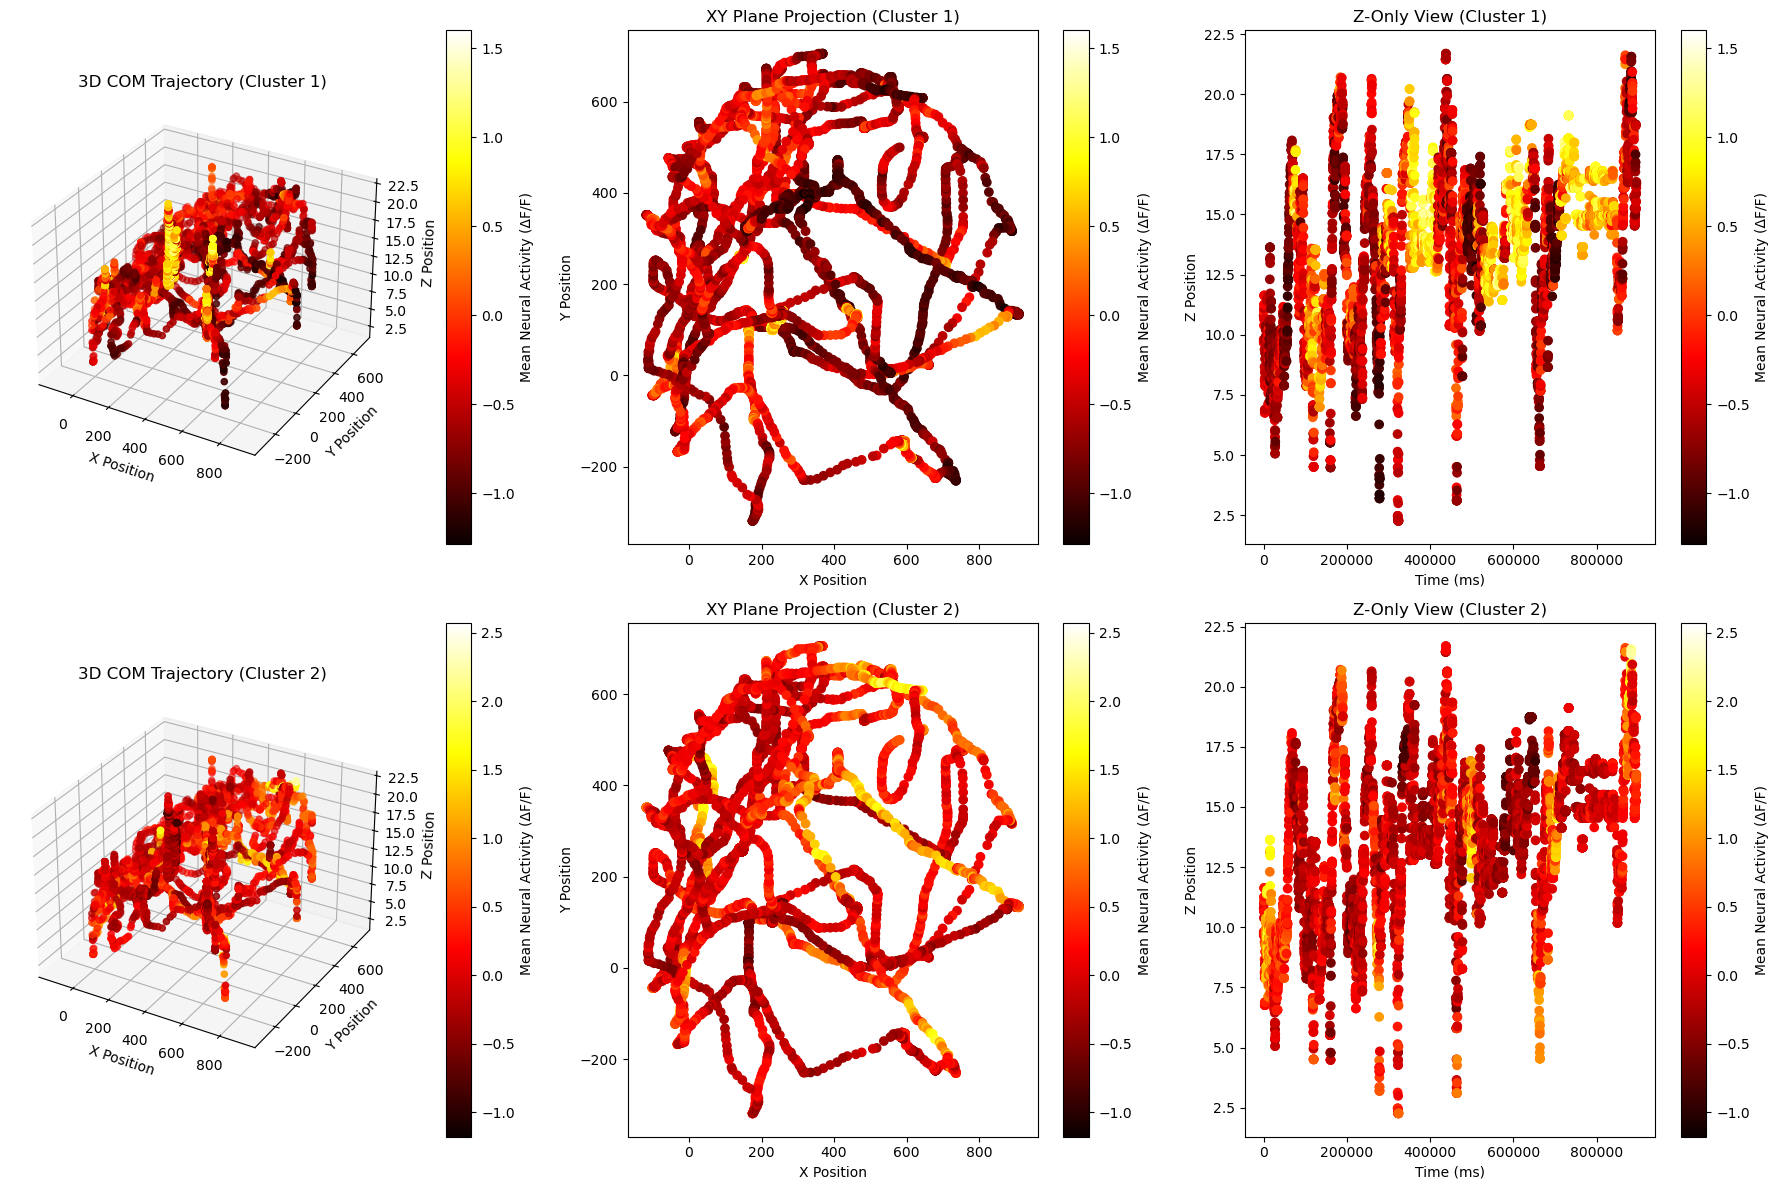

In [10]:
from scipy.cluster.hierarchy import fcluster
# df_new = df_new.reset_index()


# time = df_new['timestamp_ms_mini']
# Step 1: Assign neurons to clusters
num_clusters = 2
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')  # Cluster labels for neurons (1 or 2)

# Step 2: Compute mean activity for each cluster
cluster_means = []
for cluster_id in range(1, num_clusters + 1):
    # Select neurons in the current cluster
    cluster_neurons = neuron_activity_normalized[cluster_labels == cluster_id, :]
    # Compute mean activity across neurons in this cluster
    cluster_mean = cluster_neurons.mean(axis=0)
    cluster_means.append(cluster_mean)

# Convert to a NumPy array for easier indexing
cluster_means = np.array(cluster_means)

# Step 3: Create plots for each cluster
fig = plt.figure(figsize=(18, 12))

# Plot for each cluster
for cluster_id in range(num_clusters):
    row_offset = cluster_id * 3  # Offset for each cluster's row

    # 3D Scatter Plot
    ax1 = fig.add_subplot(2, 3, row_offset + 1, projection='3d')
    scatter = ax1.scatter(
        df_new['com_x'], df_new['com_y'], df_new['com_z'],
        c=cluster_means[cluster_id, :len(df_new['com_x'])],  # Cluster mean activity
        cmap='hot', marker='o'
    )
    ax1.set_title(f'3D COM Trajectory (Cluster {cluster_id + 1})')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_zlabel('Z Position')
    fig.colorbar(scatter, ax=ax1, pad=0.1, label='Mean Neural Activity (ΔF/F)')

    # XY Plane Projection
    ax2 = fig.add_subplot(2, 3, row_offset + 2)
    scatter_xy = ax2.scatter(
        df_new['com_x'], df_new['com_y'],
        c=cluster_means[cluster_id, :len(df_new['com_x'])],  # Cluster mean activity
        cmap='hot', marker='o'
    )
    ax2.set_title(f'XY Plane Projection (Cluster {cluster_id + 1})')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    fig.colorbar(scatter_xy, ax=ax2, label='Mean Neural Activity (ΔF/F)')

    # Z-Only View
    ax3 = fig.add_subplot(2, 3, row_offset + 3)
    scatter_z = ax3.scatter(
        time, df_new['com_z'],
        c=cluster_means[cluster_id, :len(df_new['com_z'])],  # Cluster mean activity
        cmap='hot', marker='o'
    )
    ax3.set_title(f'Z-Only View (Cluster {cluster_id + 1})')
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Z Position')
    fig.colorbar(scatter_z, ax=ax3, label='Mean Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


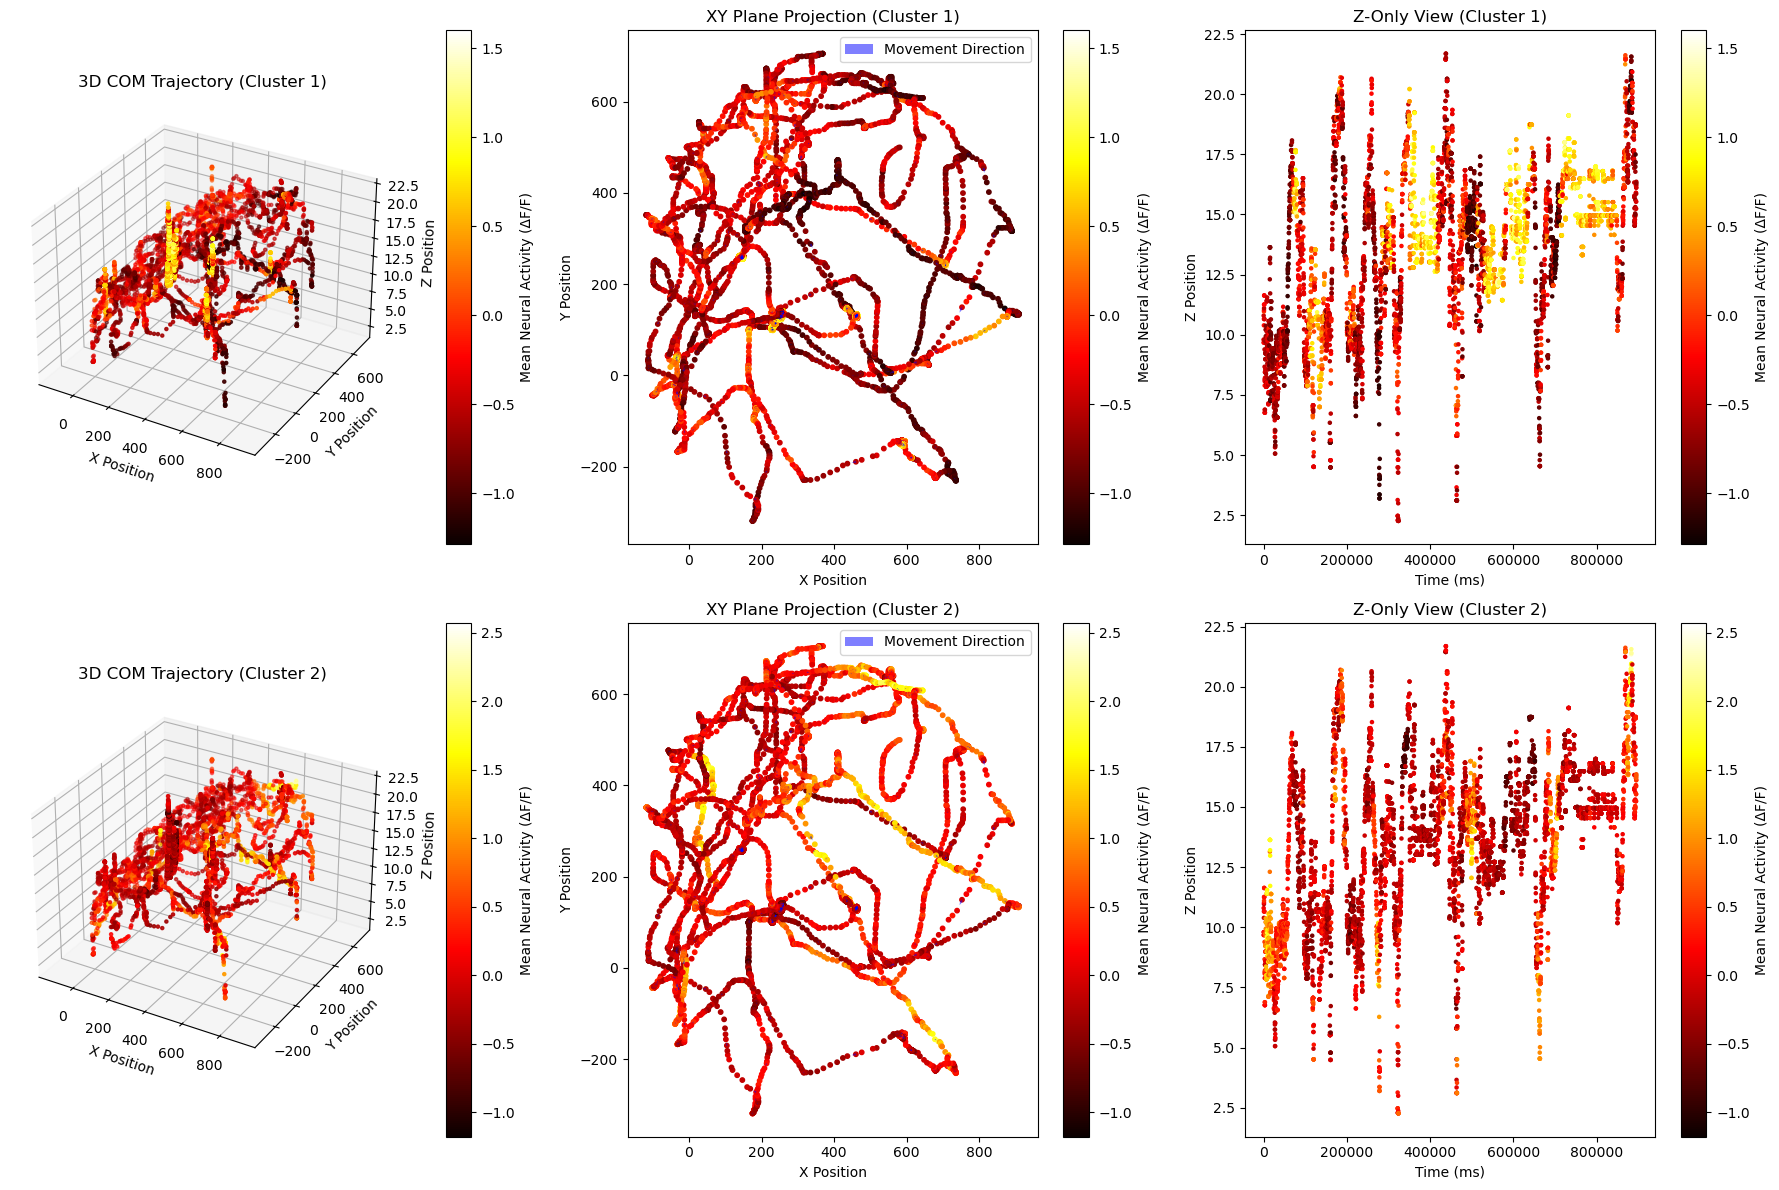

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from scipy.cluster.hierarchy import fcluster

# Assume Z, df_new, neuron_activity_normalized, time are already defined.
num_clusters = 2
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')

# Compute mean activity for each cluster
cluster_means = []
for cluster_id in range(1, num_clusters + 1):
    cluster_neurons = neuron_activity_normalized[cluster_labels == cluster_id, :]
    cluster_mean = cluster_neurons.mean(axis=0)
    cluster_means.append(cluster_mean)
cluster_means = np.array(cluster_means)

# Prepare figure
fig = plt.figure(figsize=(18, 12))

# For each cluster
for cluster_id in range(num_clusters):
    row_offset = cluster_id * 3  # Adjust the subplot positions for each cluster

    # --- 3D Scatter Plot ---
    ax1 = fig.add_subplot(2, 3, row_offset + 1, projection='3d')
    scatter1 = ax1.scatter(
        df_new['com_x'], df_new['com_y'], df_new['com_z'],
        c=cluster_means[cluster_id, :len(df_new['com_x'])],
        cmap='hot', marker='o', s=5  # Smaller dot size
    )
    ax1.set_title(f'3D COM Trajectory (Cluster {cluster_id + 1})')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_zlabel('Z Position')
    fig.colorbar(scatter1, ax=ax1, pad=0.1, label='Mean Neural Activity (ΔF/F)')

    # --- XY Plane Projection with Trajectory Arrows ---
    ax2 = fig.add_subplot(2, 3, row_offset + 2)
    scatter2 = ax2.scatter(
        df_new['com_x'], df_new['com_y'],
        c=cluster_means[cluster_id, :len(df_new['com_x'])],
        cmap='hot', marker='o', s=10#2  # Smaller dot size
    )
    ax2.set_title(f'XY Plane Projection (Cluster {cluster_id + 1})')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    fig.colorbar(scatter2, ax=ax2, label='Mean Neural Activity (ΔF/F)')

    # Compute trajectory differences for quiver plot:
    x = np.array(df_new['com_x'])
    y = np.array(df_new['com_y'])
    dx = np.diff(x)
    dy = np.diff(y)
    
    # To avoid a cluttered plot, subsample the data (e.g., every 10th point)
    step = 10 if len(x) > 100 else 1
    ax2.quiver(x[:-1:step], y[:-1:step], dx[::step], dy[::step],
               angles='xy', scale_units='xy', scale=2, color='blue', alpha=0.5,
               label='Movement Direction')
    ax2.legend()

    # --- Z-Only View ---
    ax3 = fig.add_subplot(2, 3, row_offset + 3)
    scatter3 = ax3.scatter(
        time, df_new['com_z'],
        c=cluster_means[cluster_id, :len(df_new['com_z'])],
        cmap='hot', marker='o', s=5  # Smaller dot size
    )
    ax3.set_title(f'Z-Only View (Cluster {cluster_id + 1})')
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Z Position')
    fig.colorbar(scatter3, ax=ax3, label='Mean Neural Activity (ΔF/F)')

plt.tight_layout()
plt.show()


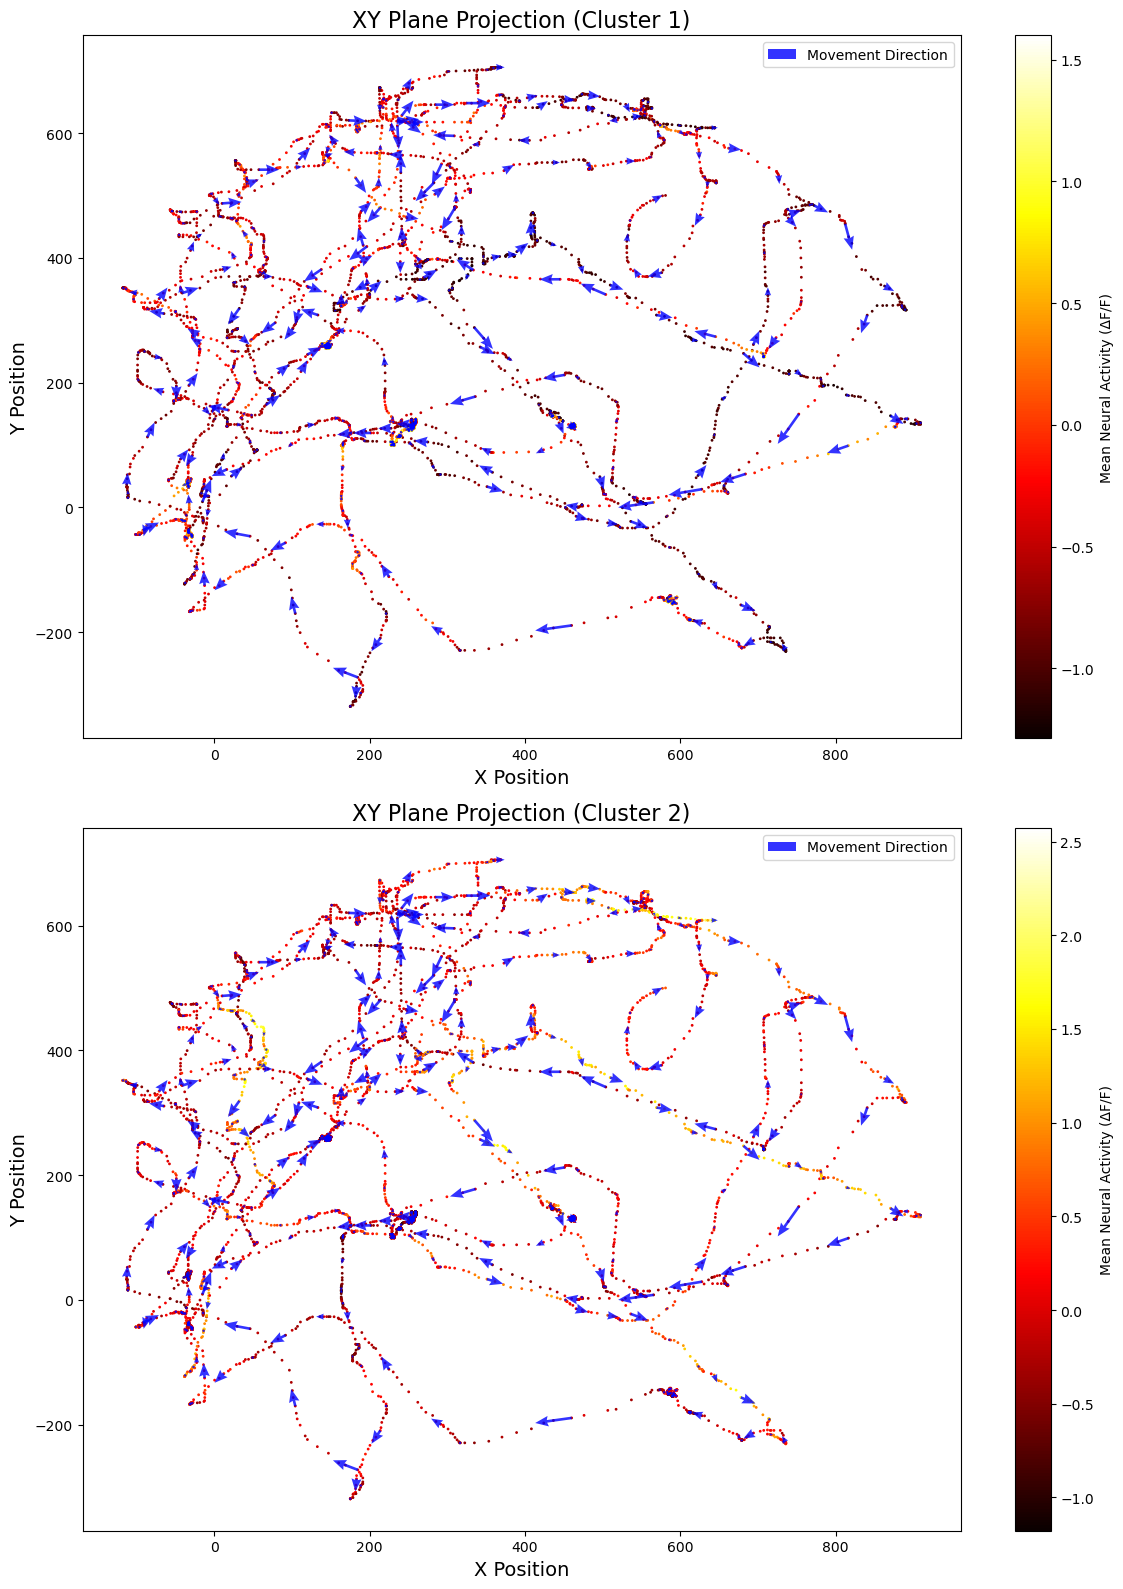

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Assume Z, df_new, neuron_activity_normalized, and time are already defined.
num_clusters = 2
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')

# Compute mean activity for each cluster
cluster_means = []
for cluster_id in range(1, num_clusters + 1):
    cluster_neurons = neuron_activity_normalized[cluster_labels == cluster_id, :]
    cluster_mean = cluster_neurons.mean(axis=0)
    cluster_means.append(cluster_mean)
cluster_means = np.array(cluster_means)

# Prepare a larger figure with only two rows for the XY projections

fig, axes = plt.subplots(nrows=num_clusters, ncols=1, figsize=(12, 16))

# For each cluster, create an XY plot with trajectory arrows
for cluster_id in range(num_clusters):
    ax = axes[cluster_id]

    # Scatter plot with small dots
    scatter = ax.scatter(
        df_new['com_x'], df_new['com_y'],
        c=cluster_means[cluster_id, :len(df_new['com_x'])],
        cmap='hot', marker='o', s=1  # Very small dots for better visibility
    )
    ax.set_title(f'XY Plane Projection (Cluster {cluster_id + 1})', fontsize=16)
    ax.set_xlabel('X Position', fontsize=14)
    ax.set_ylabel('Y Position', fontsize=14)
    fig.colorbar(scatter, ax=ax, label='Mean Neural Activity (ΔF/F)')

    # Compute trajectory differences for quiver plot
    x = np.array(df_new['com_x'])
    y = np.array(df_new['com_y'])
    dx = np.diff(x)
    dy = np.diff(y)

    # Subsample to avoid clutter
    step = 10 if len(x) > 100 else 1
    ax.quiver(x[:-1:step], y[:-1:step], dx[::step], dy[::step],
              angles='xy', scale_units='xy', scale=0.5, color='blue', alpha=0.8,
              width=0.003, headwidth=4, headlength=5, label='Movement Direction')

    ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


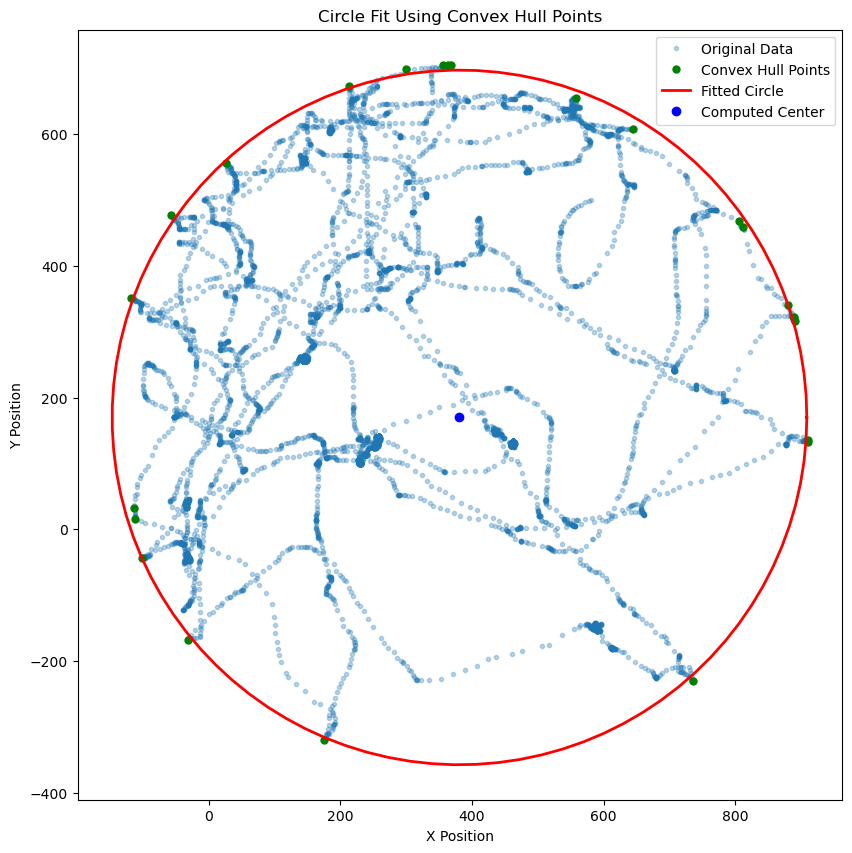

The computed radius of the fitted circle is: 527.389429806227


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.spatial import ConvexHull

# Original data (assumed to be in df_new)
x = np.array(df_new['com_x'])
y = np.array(df_new['com_y'])
points = np.column_stack((x, y))

# Compute the convex hull to approximate the outer boundary
hull = ConvexHull(points)
hull_points = points[hull.vertices]
hx, hy = hull_points[:, 0], hull_points[:, 1]

def residuals(params, x_data, y_data):
    xc, yc, r = params
    return np.sqrt((x_data - xc)**2 + (y_data - yc)**2) - r

# Initial guess based on the hull points
initial_guess = [
    np.mean(hx), 
    np.mean(hy), 
    np.mean(np.sqrt((hx - np.mean(hx))**2 + (hy - np.mean(hy))**2))
]

result = least_squares(residuals, initial_guess, args=(hx, hy))
xc, yc, r = result.x

# Generate points for the fitted circle
theta = np.linspace(0, 2*np.pi, 100)
circle_x = xc + r * np.cos(theta)
circle_y = yc + r * np.sin(theta)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, y, 'o', ms=3, alpha=0.3, label='Original Data')
ax.plot(hx, hy, 'go', ms=5, label='Convex Hull Points')
ax.plot(circle_x, circle_y, 'r-', lw=2, label='Fitted Circle')
ax.plot(xc, yc, 'bo', label='Computed Center')
ax.set_aspect('equal', 'box')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Circle Fit Using Convex Hull Points')
ax.legend()
plt.show()
# Print the computed radius of the fitted circle
print(f"The computed radius of the fitted circle is: {r} mm")


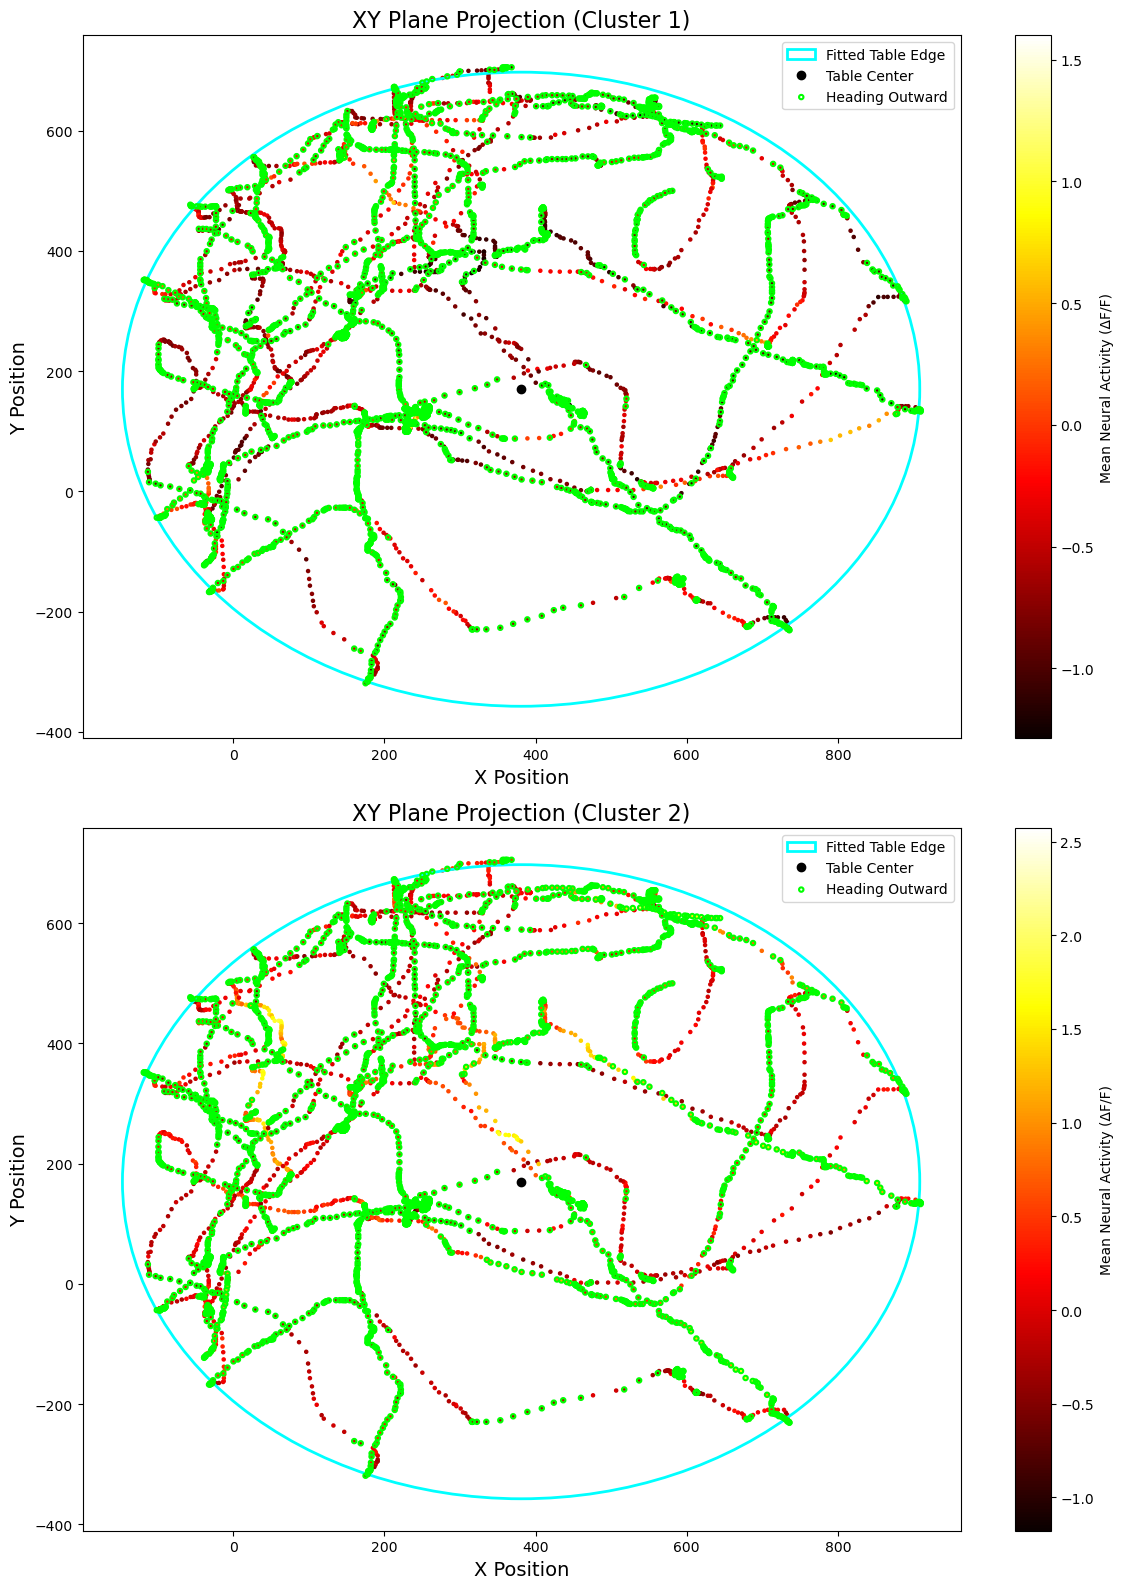

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares
from scipy.signal import savgol_filter  # Optional smoothing if needed

# -------------------------
# Step 1: Fit a circle to the table edge using the convex hull
# -------------------------

# Use the COM data from df_new (assumed to be defined)
x_all = np.array(df_new['com_x'])
y_all = np.array(df_new['com_y'])
points = np.column_stack((x_all, y_all))

# Compute the convex hull of the COM data
hull = ConvexHull(points)
hull_points = points[hull.vertices]
hx, hy = hull_points[:, 0], hull_points[:, 1]

# Define a residual function for circle fitting:
def residuals(params, x_data, y_data):
    xc, yc, r = params
    return np.sqrt((x_data - xc)**2 + (y_data - yc)**2) - r

# Initial guess: use the mean of the hull points for the center and the average distance for the radius
initial_guess = [np.mean(hx), np.mean(hy), np.mean(np.sqrt((hx - np.mean(hx))**2 + (hy - np.mean(hy))**2))]
result = least_squares(residuals, initial_guess, args=(hx, hy))
xc, yc, r = result.x

# -------------------------
# Step 2: Determine the heading direction (towards edge or not)
# -------------------------
# Compute instantaneous velocities from the positions (simple differences)
dx = np.diff(x_all)
dy = np.diff(y_all)
# For each point (from index 1 onward) compute the vector from the fitted center
vec_x = x_all[1:] - xc
vec_y = y_all[1:] - yc
# Dot product: if positive, the mouse is moving outward
dot = dx * vec_x + dy * vec_y
heading_out = dot > 0  # Boolean array of length len(x_all)-1
# Create indices (shifting by 1 so they align with positions) for which the mouse is heading outward
heading_indices = np.where(heading_out)[0] + 1

# -------------------------
# Step 3: Neural clusters and XY projection plots
# -------------------------
num_clusters = 2
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')

# Compute mean activity for each cluster
cluster_means = []
for cluster_id in range(1, num_clusters + 1):
    cluster_neurons = neuron_activity_normalized[cluster_labels == cluster_id, :]
    cluster_mean = cluster_neurons.mean(axis=0)
    cluster_means.append(cluster_mean)
cluster_means = np.array(cluster_means)

# Create a figure with one subplot per cluster
fig, axes = plt.subplots(nrows=num_clusters, ncols=1, figsize=(12, 16))

for cluster_id in range(num_clusters):
    ax = axes[cluster_id]

    # Scatter plot: positions colored by neural activity (using the 'hot' colormap)
    scatter = ax.scatter(
        x_all, y_all,
        c=cluster_means[cluster_id, :len(x_all)],
        cmap='hot', marker='o', s=5  # s=1 for very small dots
    )
    ax.set_title(f'XY Plane Projection (Cluster {cluster_id + 1})', fontsize=16)
    ax.set_xlabel('X Position', fontsize=14)
    ax.set_ylabel('Y Position', fontsize=14)
    fig.colorbar(scatter, ax=ax, label='Mean Neural Activity (ΔF/F)')

    # Overlay the fitted circle (table edge)
    circle = plt.Circle((xc, yc), r, color='cyan', fill=False, lw=2, label='Fitted Table Edge')
    ax.add_patch(circle)
    
    # Mark the computed table center
    ax.plot(xc, yc, 'ko', label='Table Center')
    
    # Overlay markers for time points when the mouse is heading outward.
    # Here, we plot these as slightly larger, non-filled markers.
    ax.scatter(x_all[heading_indices], y_all[heading_indices],
               s=10, facecolors='none', edgecolors='lime', linewidths=1.5, 
               label='Heading Outward')
    
    ax.legend()

plt.tight_layout()
plt.show()


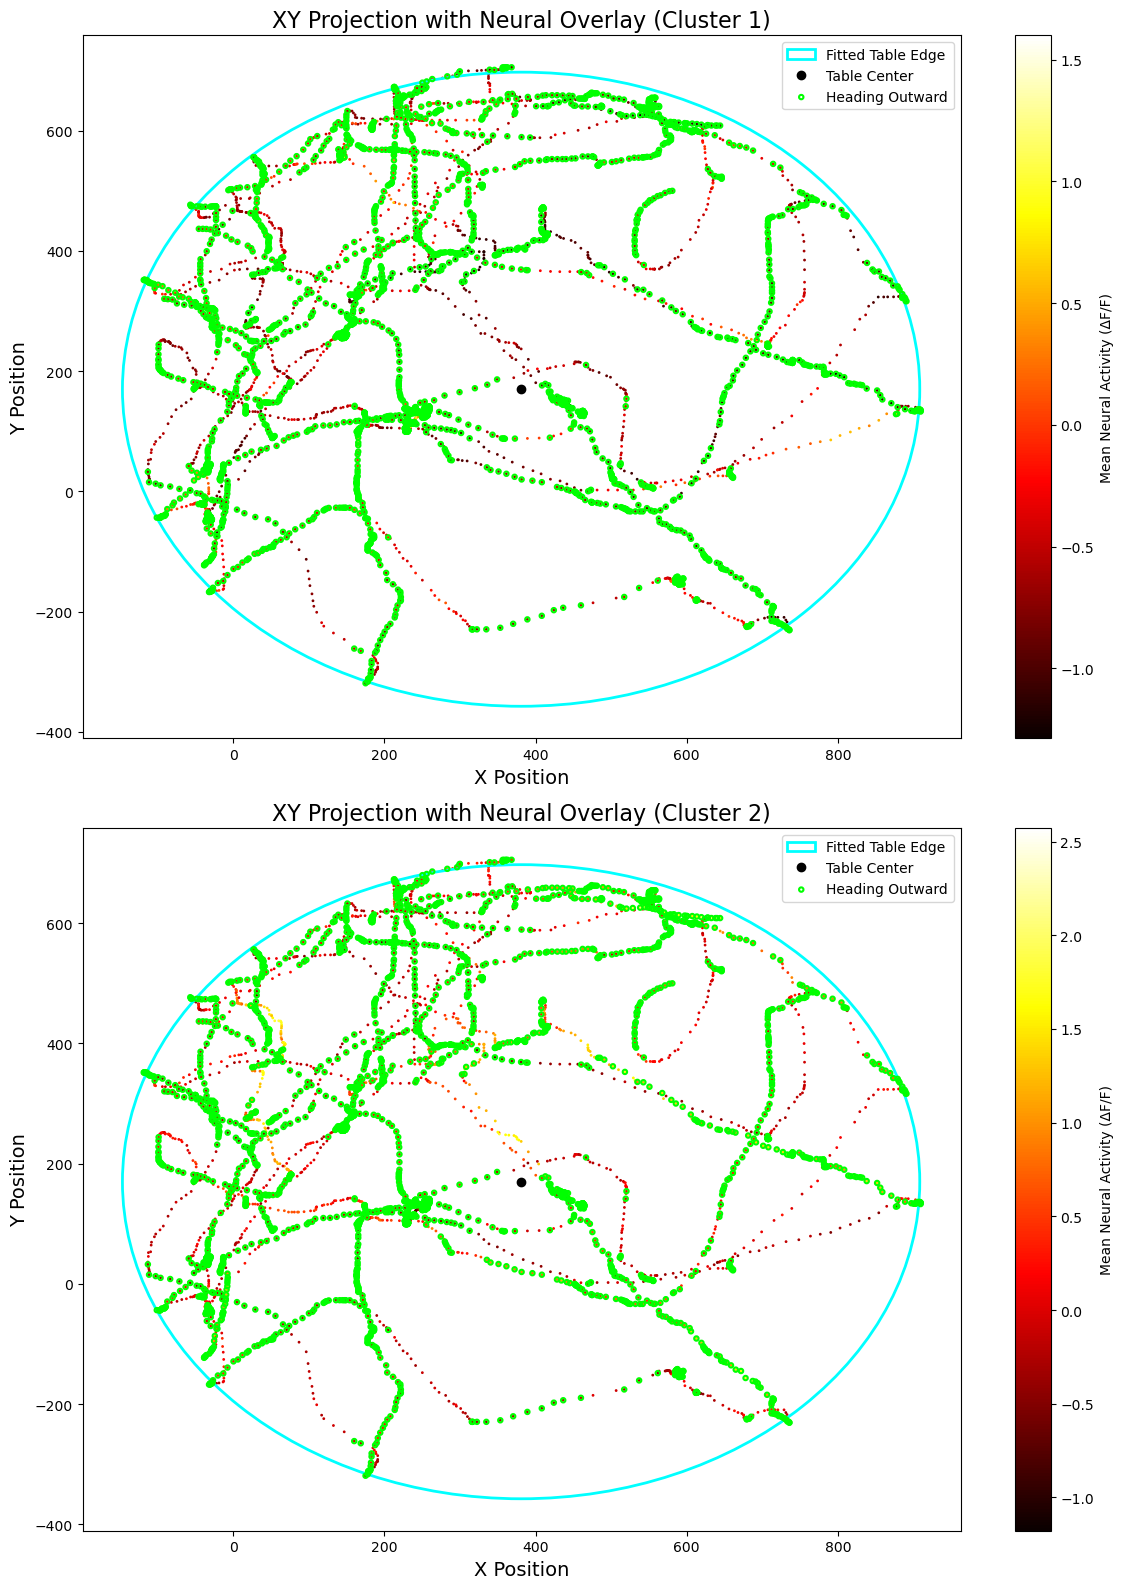

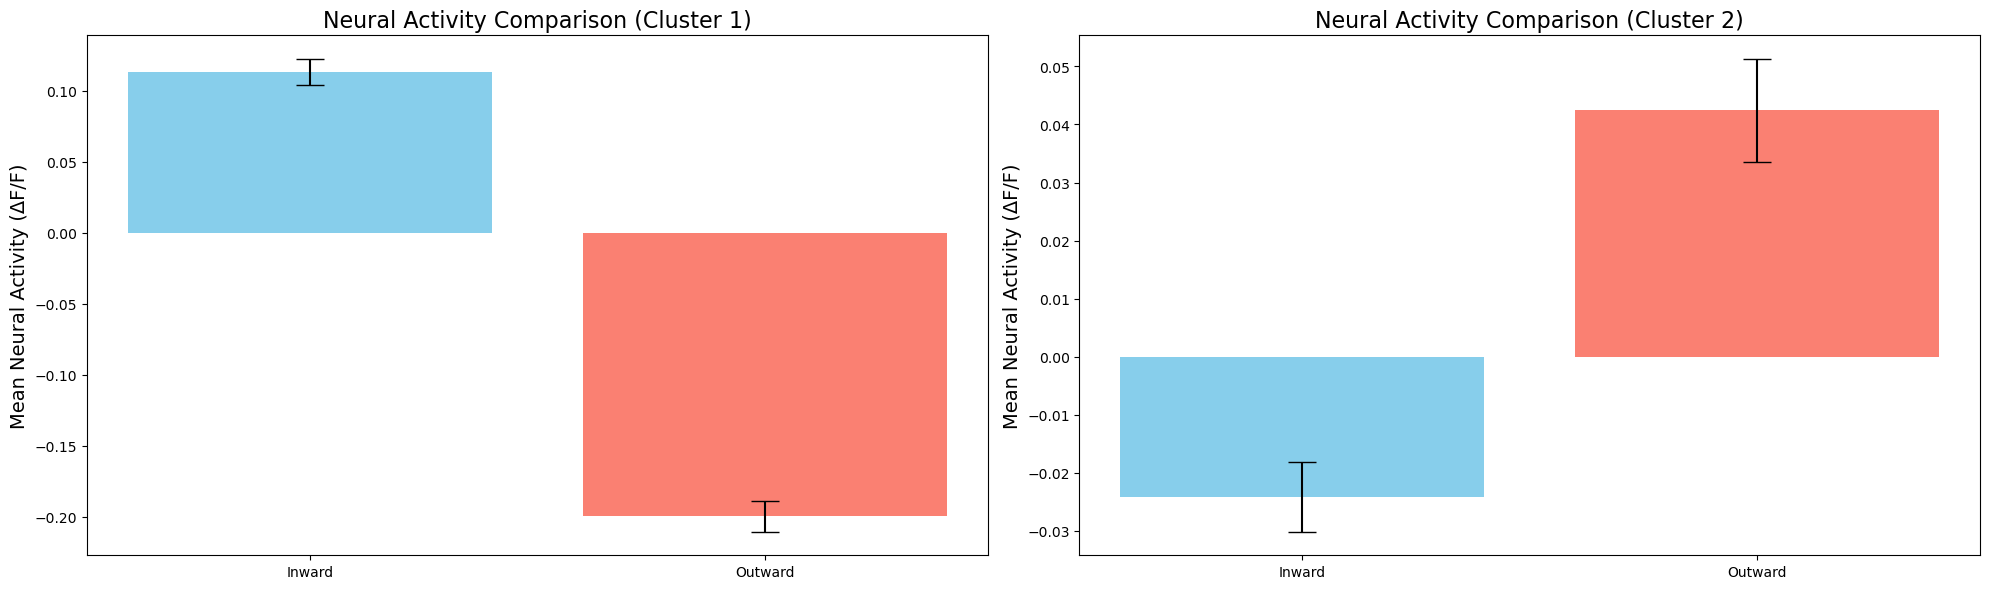

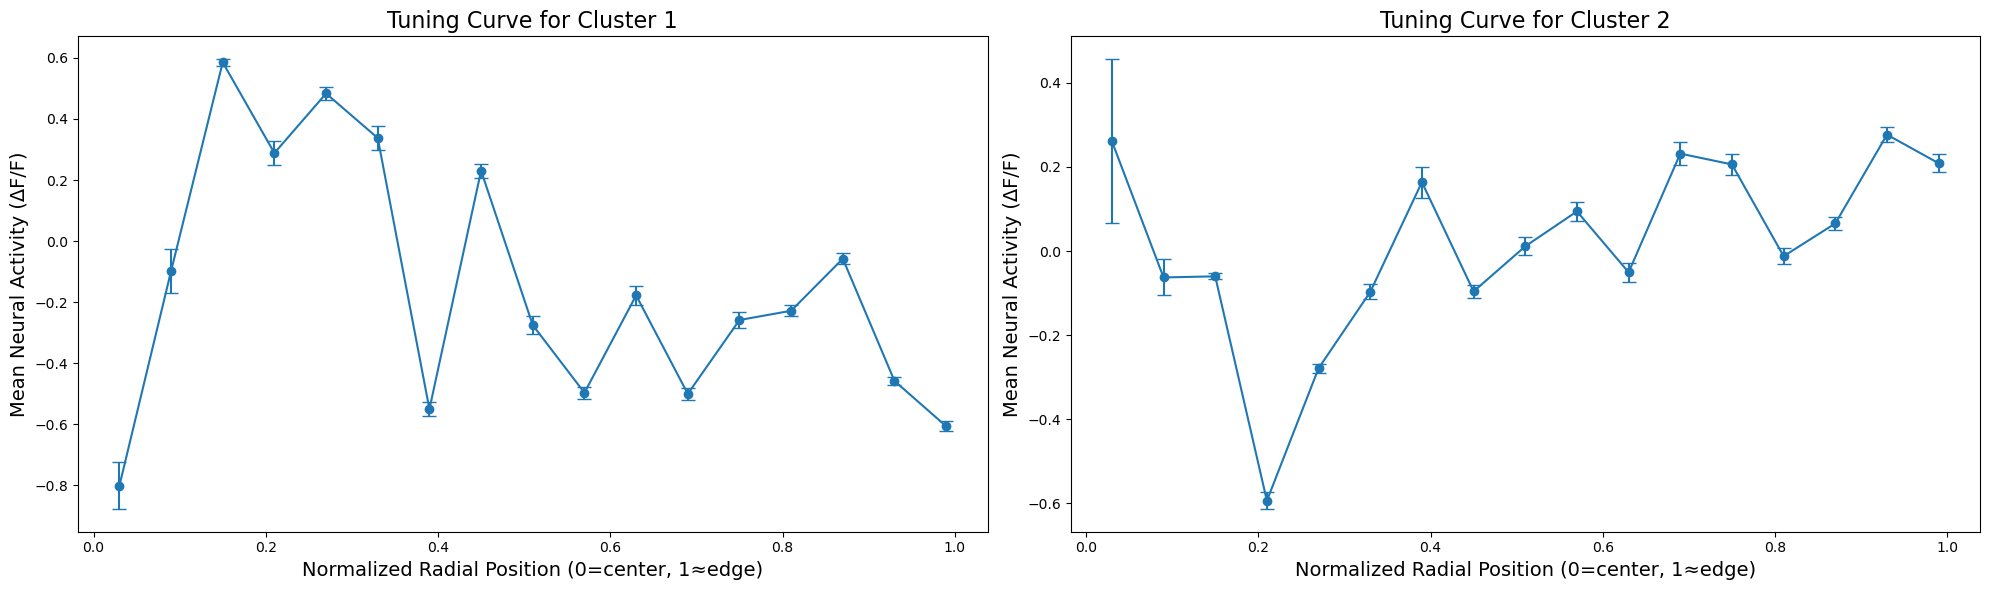

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares
from scipy import stats

# ========
# ASSUMPTIONS:
#   - df_new is a DataFrame with columns 'com_x' and 'com_y'
#   - neuron_activity_normalized is an array of shape (n_neurons, n_timepoints)
#   - Z (the linkage matrix) is defined for hierarchical clustering
#   - time is defined if needed (not used in these new plots)
# ========

# -------------------------
# Step 1: Fit a circle to the table edge using the convex hull
# -------------------------
x_all = np.array(df_new['com_x'])
y_all = np.array(df_new['com_y'])
points = np.column_stack((x_all, y_all))

# Compute the convex hull (outer boundary of the COM data)
hull = ConvexHull(points)
hull_points = points[hull.vertices]
hx, hy = hull_points[:, 0], hull_points[:, 1]

# Define a residual function for circle fitting:
def residuals(params, x_data, y_data):
    xc, yc, r = params
    return np.sqrt((x_data - xc)**2 + (y_data - yc)**2) - r

# Initial guess: use the mean of the hull points for the center and the average distance for the radius
initial_guess = [np.mean(hx), np.mean(hy), np.mean(np.sqrt((hx - np.mean(hx))**2 + (hy - np.mean(hy))**2))]
result = least_squares(residuals, initial_guess, args=(hx, hy))
xc, yc, r = result.x

# -------------------------
# Step 2: Determine heading direction (toward edge or not)
# -------------------------
# Compute instantaneous differences (a simple approximation for velocity)
dx = np.diff(x_all)
dy = np.diff(y_all)

# For each point (starting from index 1), compute the vector from the fitted center
vec_x = x_all[1:] - xc
vec_y = y_all[1:] - yc

# Dot product: if positive, the mouse is moving outward (toward the edge)
dot = dx * vec_x + dy * vec_y
heading_out = dot > 0  # Boolean array of length (n_timepoints - 1)

# Create indices for outward heading (we shift by one so they align with the positions in x_all, y_all)
heading_indices = np.where(heading_out)[0] + 1
# Define indices for inward (or non-outward) movement
all_indices = np.arange(1, len(x_all))
inward_indices = np.setdiff1d(all_indices, heading_indices)

# -------------------------
# Step 3: Compute neural cluster mean activity
# -------------------------
num_clusters = 2
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')

cluster_means = []
for cluster_id in range(1, num_clusters + 1):
    # Select neurons belonging to the current cluster and compute mean across neurons
    cluster_neurons = neuron_activity_normalized[cluster_labels == cluster_id, :]
    cluster_mean = cluster_neurons.mean(axis=0)
    cluster_means.append(cluster_mean)
cluster_means = np.array(cluster_means)  # Shape: (num_clusters, n_timepoints)

# -------------------------
# Visualization A: Scatter Plot with Fitted Circle & Outward Markers (for context)
# -------------------------
fig1, axes1 = plt.subplots(nrows=num_clusters, ncols=1, figsize=(12, 16))
for c in range(num_clusters):
    ax = axes1[c]
    scatter = ax.scatter(x_all, y_all,
                         c=cluster_means[c, :len(x_all)],
                         cmap='hot', marker='o', s=1)
    ax.set_title(f'XY Projection with Neural Overlay (Cluster {c+1})', fontsize=16)
    ax.set_xlabel('X Position', fontsize=14)
    ax.set_ylabel('Y Position', fontsize=14)
    fig1.colorbar(scatter, ax=ax, label='Mean Neural Activity (ΔF/F)')
    # Overlay the fitted circle and center
    circle = plt.Circle((xc, yc), r, color='cyan', fill=False, lw=2, label='Fitted Table Edge')
    ax.add_patch(circle)
    ax.plot(xc, yc, 'ko', label='Table Center')
    # Mark time points when heading outward
    ax.scatter(x_all[heading_indices], y_all[heading_indices],
               s=10, facecolors='none', edgecolors='lime', linewidths=1.5,
               label='Heading Outward')
    ax.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Visualization B: Bar Plots of Neural Activity for Outward vs. Inward Movements
# -------------------------
# We’ll only use time points from index 1 onward (since heading was computed there)
activity_data = {}  # To store mean and SEM for each cluster and condition
cluster_names = [f'Cluster {i+1}' for i in range(num_clusters)]
for c in range(num_clusters):
    # Get neural activity for this cluster (using indices from 1 onward)
    activity = cluster_means[c, 1:]
    # Split into outward and inward conditions
    outward_act = activity[heading_indices - 1]  # shift indices back by 1
    inward_act = activity[inward_indices - 1]
    mean_out = np.mean(outward_act)
    mean_in = np.mean(inward_act)
    sem_out = stats.sem(outward_act)
    sem_in = stats.sem(inward_act)
    activity_data[c] = {'outward': (mean_out, sem_out),
                        'inward': (mean_in, sem_in)}

# Plot bar charts
fig2, axes2 = plt.subplots(nrows=1, ncols=num_clusters, figsize=(10*num_clusters, 6))
if num_clusters == 1:
    axes2 = [axes2]
for c in range(num_clusters):
    ax = axes2[c]
    means = [activity_data[c]['inward'][0], activity_data[c]['outward'][0]]
    sems = [activity_data[c]['inward'][1], activity_data[c]['outward'][1]]
    ax.bar(['Inward', 'Outward'], means, yerr=sems, capsize=10, color=['skyblue', 'salmon'])
    ax.set_title(f'Neural Activity Comparison ({cluster_names[c]})', fontsize=16)
    ax.set_ylabel('Mean Neural Activity (ΔF/F)', fontsize=14)
plt.tight_layout()
plt.show()

# -------------------------
# Visualization C: Tuning Curves Based on Normalized Radial Position
# -------------------------
# Compute the radial distance for each time point and normalize by the fitted radius
r_points = np.sqrt((x_all - xc)**2 + (y_all - yc)**2)
norm_r = r_points / r  # 0 = center, ~1 = edge (or slightly more)

# Bin the normalized radius values
bins = np.linspace(0, 1.2, 21)
bin_centers = 0.5*(bins[:-1] + bins[1:])

tuning_data = {}
for c in range(num_clusters):
    activity = cluster_means[c, :]
    mean_act = []
    sem_act = []
    for i in range(len(bins)-1):
        mask = (norm_r >= bins[i]) & (norm_r < bins[i+1])
        if np.sum(mask) > 0:
            mean_act.append(np.mean(activity[mask]))
            sem_act.append(stats.sem(activity[mask]))
        else:
            mean_act.append(np.nan)
            sem_act.append(np.nan)
    tuning_data[c] = {'bin_centers': bin_centers, 'mean': np.array(mean_act), 'sem': np.array(sem_act)}

# Plot tuning curves for each cluster
fig3, axes3 = plt.subplots(nrows=1, ncols=num_clusters, figsize=(10*num_clusters, 6))
if num_clusters == 1:
    axes3 = [axes3]
for c in range(num_clusters):
    ax = axes3[c]
    ax.errorbar(tuning_data[c]['bin_centers'], tuning_data[c]['mean'],
                yerr=tuning_data[c]['sem'], fmt='-o', capsize=5)
    ax.set_title(f'Tuning Curve for {cluster_names[c]}', fontsize=16)
    ax.set_xlabel('Normalized Radial Position (0=center, 1≈edge)', fontsize=14)
    ax.set_ylabel('Mean Neural Activity (ΔF/F)', fontsize=14)
plt.tight_layout()
plt.show()


In [42]:
heading_indices

array([   1,    2,    4, ..., 8891, 8892, 8893])

In [37]:
import numpy as np
from scipy import stats

# For each cluster, perform an in-depth statistical analysis comparing outward vs. inward activity.
for cluster in range(num_clusters):
    # Use time points from index 1 onward (since heading direction was computed from differences)
    # Adjust indices so that they match the neural activity vector length.
    # (If your activity array is indexed starting at 0 but heading_indices are computed from diff,
    # you might need to subtract one to align them. Here we assume heading_indices and inward_indices are aligned.)
    
    activity = cluster_means[cluster, 1:]
    
    # Extract activity for outward and inward conditions.
    # (Assuming heading_indices and inward_indices are computed relative to x_all[1:], y_all[1:])
    outward_act = activity[heading_indices - 1]   # Adjust if necessary
    inward_act = activity[inward_indices - 1]
    
    # Descriptive statistics:
    mean_out = np.mean(outward_act)
    std_out = np.std(outward_act, ddof=1)
    median_out = np.median(outward_act)
    n_out = len(outward_act)
    
    mean_in = np.mean(inward_act)
    std_in = np.std(inward_act, ddof=1)
    median_in = np.median(inward_act)
    n_in = len(inward_act)
    
    print(f"Cluster {cluster+1} Analysis:")
    print("----------------------------")
    print(f"Outward Movement: n = {n_out}, Mean = {mean_out:.4f}, Median = {median_out:.4f}, Std = {std_out:.4f}")
    print(f"Inward Movement:  n = {n_in}, Mean = {mean_in:.4f}, Median = {median_in:.4f}, Std = {std_in:.4f}")
    
    # Statistical tests:
    # Two-sample t-test (assuming independent samples with unequal variances)
    ttest_res = stats.ttest_ind(outward_act, inward_act, equal_var=False)
    print(f"T-test: t = {ttest_res.statistic:.4f}, p = {ttest_res.pvalue:.4f}")
    
    # Mann-Whitney U test (nonparametric)
    mwu_res = stats.mannwhitneyu(outward_act, inward_act, alternative='two-sided')
    print(f"Mann-Whitney U test: U = {mwu_res.statistic:.4f}, p = {mwu_res.pvalue:.4f}")
    
    # Compute effect size (Cohen's d)
    pooled_std = np.sqrt(((n_out - 1) * std_out**2 + (n_in - 1) * std_in**2) / (n_out + n_in - 2))
    cohen_d = (mean_out - mean_in) / pooled_std
    print(f"Cohen's d: {cohen_d:.4f}")
    print("\n")


Cluster 1 Analysis:
----------------------------
Outward Movement: n = 3219, Mean = -0.1994, Median = -0.3167, Std = 0.6195
Inward Movement:  n = 5674, Mean = 0.1132, Median = 0.1648, Std = 0.6877
T-test: t = -21.9639, p = 0.0000
Mann-Whitney U test: U = 6765672.0000, p = 0.0000
Cohen's d: -0.4709


Cluster 2 Analysis:
----------------------------
Outward Movement: n = 3219, Mean = 0.0424, Median = -0.0680, Std = 0.5014
Inward Movement:  n = 5674, Mean = -0.0241, Median = -0.1023, Std = 0.4534
T-test: t = 6.2216, p = 0.0000
Mann-Whitney U test: U = 9713519.0000, p = 0.0000
Cohen's d: 0.1411




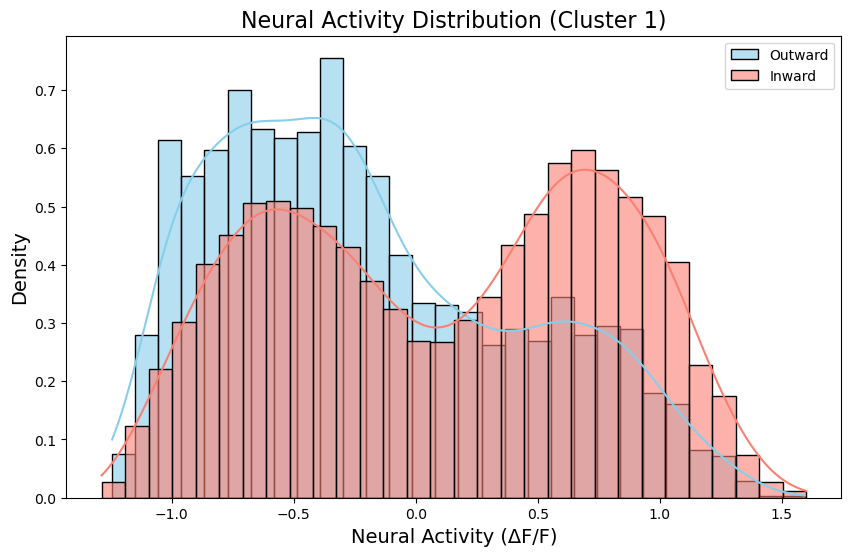

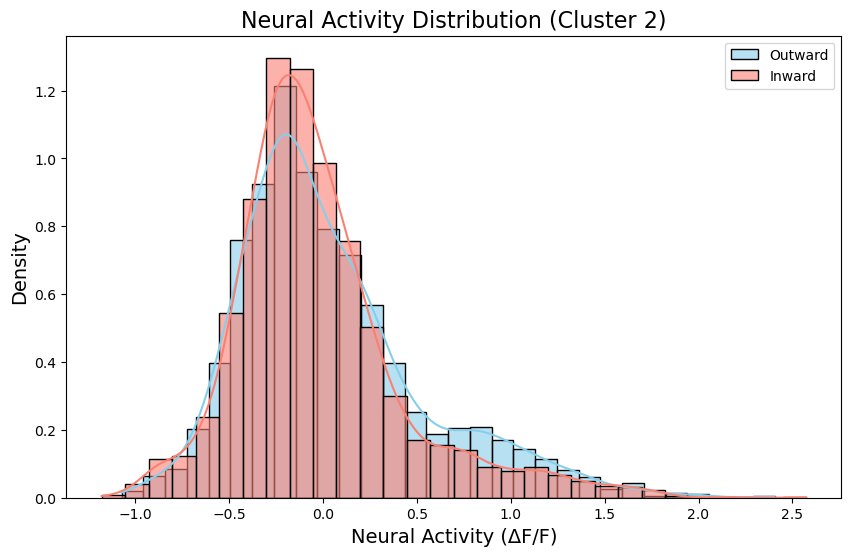

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure for each cluster
for cluster in range(num_clusters):
    # Extract neural activity for outward and inward conditions
    activity = cluster_means[cluster, 1:]
    outward_act = activity[heading_indices - 1]
    inward_act = activity[inward_indices - 1]

    # Create overlapping histograms with KDE
    plt.figure(figsize=(10, 6))
    sns.histplot(outward_act, bins=30, color='skyblue', label='Outward', kde=True, stat='density', alpha=0.6)
    sns.histplot(inward_act, bins=30, color='salmon', label='Inward', kde=True, stat='density', alpha=0.6)

    # Label the plot
    plt.title(f'Neural Activity Distribution (Cluster {cluster + 1})', fontsize=16)
    plt.xlabel('Neural Activity (ΔF/F)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend()
    plt.show()


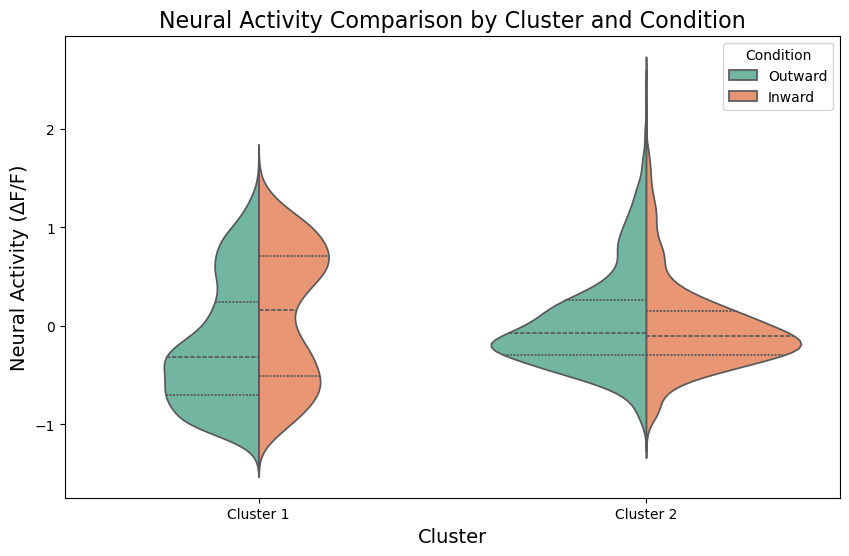

In [39]:
# Combine data into a format suitable for Seaborn
import pandas as pd

# Organize data for a violin plot
data = []
for cluster in range(num_clusters):
    activity = cluster_means[cluster, 1:]
    outward_act = activity[heading_indices - 1]
    inward_act = activity[inward_indices - 1]

    # Append data to list
    data += [{'Cluster': f'Cluster {cluster + 1}', 'Condition': 'Outward', 'Activity': val} for val in outward_act]
    data += [{'Cluster': f'Cluster {cluster + 1}', 'Condition': 'Inward', 'Activity': val} for val in inward_act]

# Convert to DataFrame
df_plot = pd.DataFrame(data)

# Plot violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Cluster', y='Activity', hue='Condition', data=df_plot, split=True, inner='quartile', palette='Set2')

# Label the plot
plt.title('Neural Activity Comparison by Cluster and Condition', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Neural Activity (ΔF/F)', fontsize=14)
plt.legend(title='Condition')
plt.show()


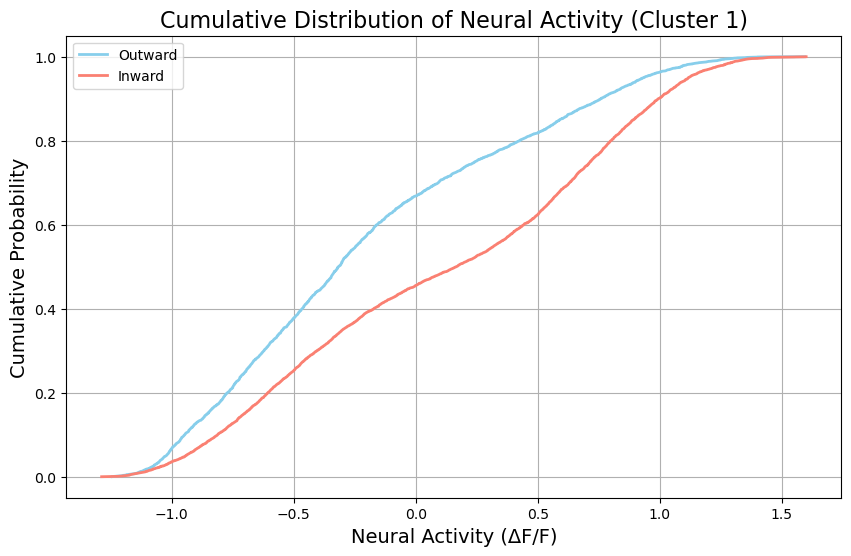

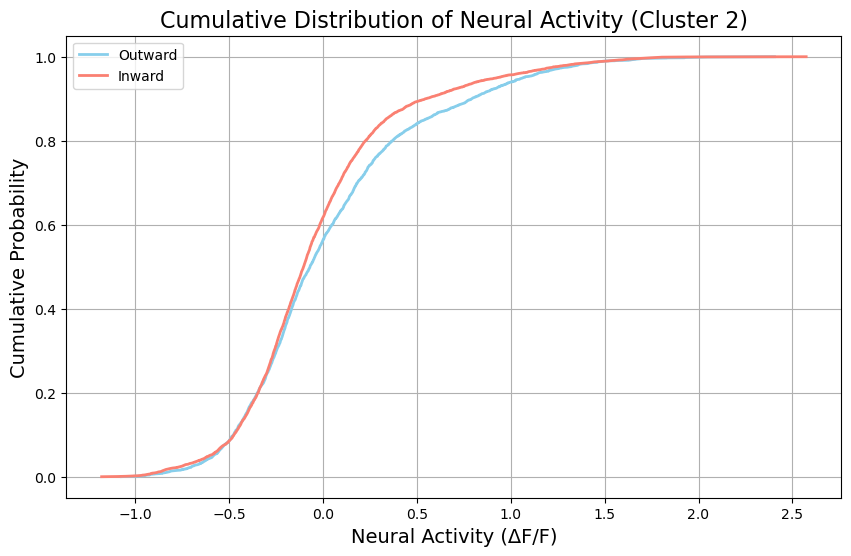

In [40]:
# Create CDF plots for each cluster
for cluster in range(num_clusters):
    activity = cluster_means[cluster, 1:]
    outward_act = np.sort(activity[heading_indices - 1])
    inward_act = np.sort(activity[inward_indices - 1])

    # Compute empirical CDFs
    cdf_out = np.arange(1, len(outward_act) + 1) / len(outward_act)
    cdf_in = np.arange(1, len(inward_act) + 1) / len(inward_act)

    # Plot the CDFs
    plt.figure(figsize=(10, 6))
    plt.plot(outward_act, cdf_out, label='Outward', color='skyblue', lw=2)
    plt.plot(inward_act, cdf_in, label='Inward', color='salmon', lw=2)

    # Label the plot
    plt.title(f'Cumulative Distribution of Neural Activity (Cluster {cluster + 1})', fontsize=16)
    plt.xlabel('Neural Activity (ΔF/F)', fontsize=14)
    plt.ylabel('Cumulative Probability', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()


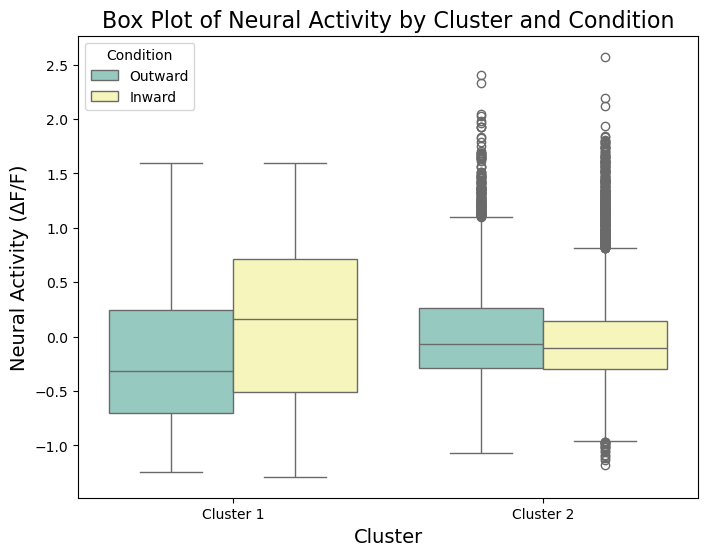

In [41]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Activity', hue='Condition', data=df_plot, palette='Set3')

# Label the plot
plt.title('Box Plot of Neural Activity by Cluster and Condition', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Neural Activity (ΔF/F)', fontsize=14)
plt.legend(title='Condition')
plt.show()


In [43]:
import numpy as np

# Number of neurons
n_neurons = neuron_activity_normalized.shape[0]

# Adjust indices: heading_indices/inward_indices were computed from diff so they correspond to timepoints 1: (assuming neural data timepoints are aligned with df_new)
heading_neural_idx = heading_indices - 1   # shift back by 1 to match neural activity indexing
inward_neural_idx = inward_indices - 1

# Preallocate arrays for the per-neuron means
mean_outward_per_neuron = np.zeros(n_neurons)
mean_inward_per_neuron = np.zeros(n_neurons)
diff_per_neuron = np.zeros(n_neurons)

# Compute mean activity for each neuron in the two conditions
for i in range(n_neurons):
    neuron_data = neuron_activity_normalized[i, :]
    mean_outward_per_neuron[i] = np.mean(neuron_data[heading_neural_idx])
    mean_inward_per_neuron[i] = np.mean(neuron_data[inward_neural_idx])
    diff_per_neuron[i] = mean_outward_per_neuron[i] - mean_inward_per_neuron[i]


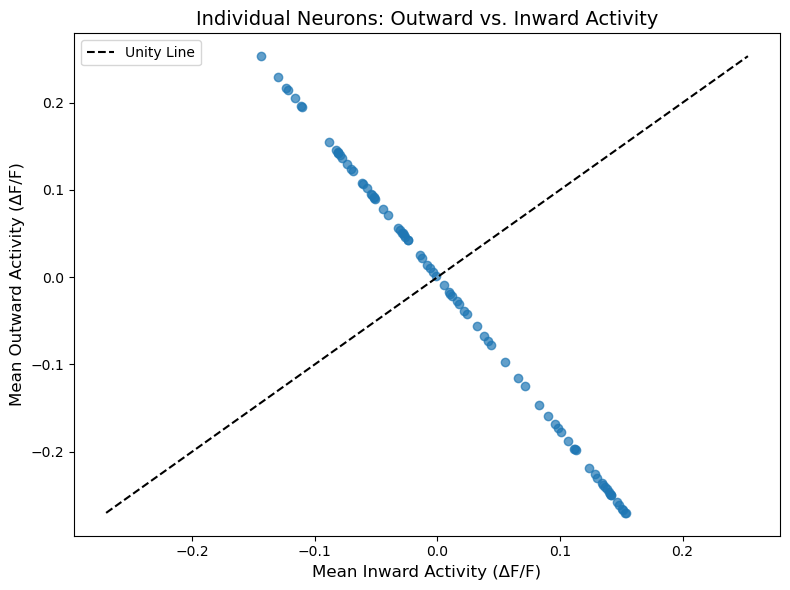

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(mean_inward_per_neuron, mean_outward_per_neuron, alpha=0.7)
plt.xlabel('Mean Inward Activity (ΔF/F)', fontsize=12)
plt.ylabel('Mean Outward Activity (ΔF/F)', fontsize=12)
plt.title('Individual Neurons: Outward vs. Inward Activity', fontsize=14)
# Plot unity line for reference:
min_val = min(np.min(mean_inward_per_neuron), np.min(mean_outward_per_neuron))
max_val = max(np.max(mean_inward_per_neuron), np.max(mean_outward_per_neuron))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Unity Line')
plt.legend()
plt.tight_layout()
plt.show()


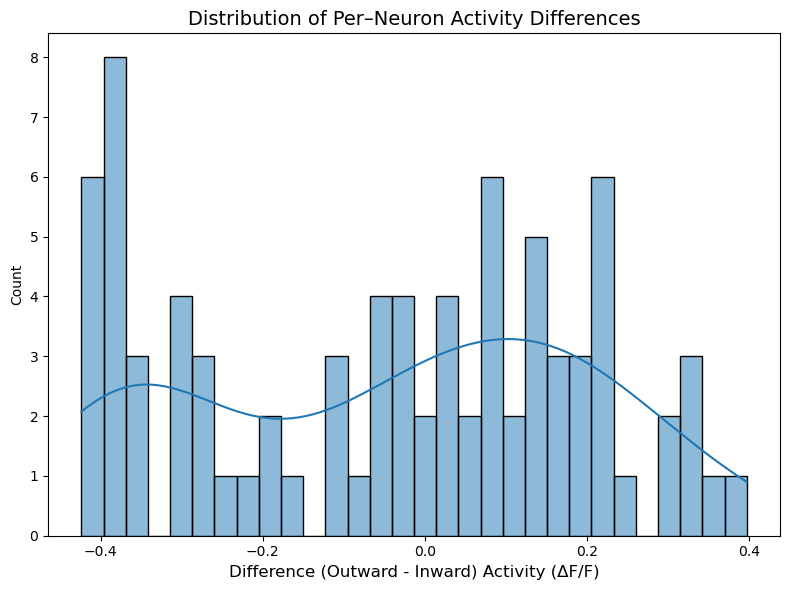

In [45]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(diff_per_neuron, bins=30, kde=True)
plt.xlabel('Difference (Outward - Inward) Activity (ΔF/F)', fontsize=12)
plt.title('Distribution of Per–Neuron Activity Differences', fontsize=14)
plt.tight_layout()
plt.show()


In [46]:
from scipy import stats

# Paired t-test across neurons
t_stat, p_value = stats.ttest_rel(mean_outward_per_neuron, mean_inward_per_neuron)
print(f"Paired t-test across neurons: t = {t_stat:.4f}, p = {p_value:.4f}")

# Compute Cohen's d for paired differences:
pooled_std = np.std(diff_per_neuron, ddof=1)
cohen_d = np.mean(diff_per_neuron) / pooled_std
print(f"Cohen's d for paired differences: {cohen_d:.4f}")


Paired t-test across neurons: t = -1.6686, p = 0.0991
Cohen's d for paired differences: -0.1843


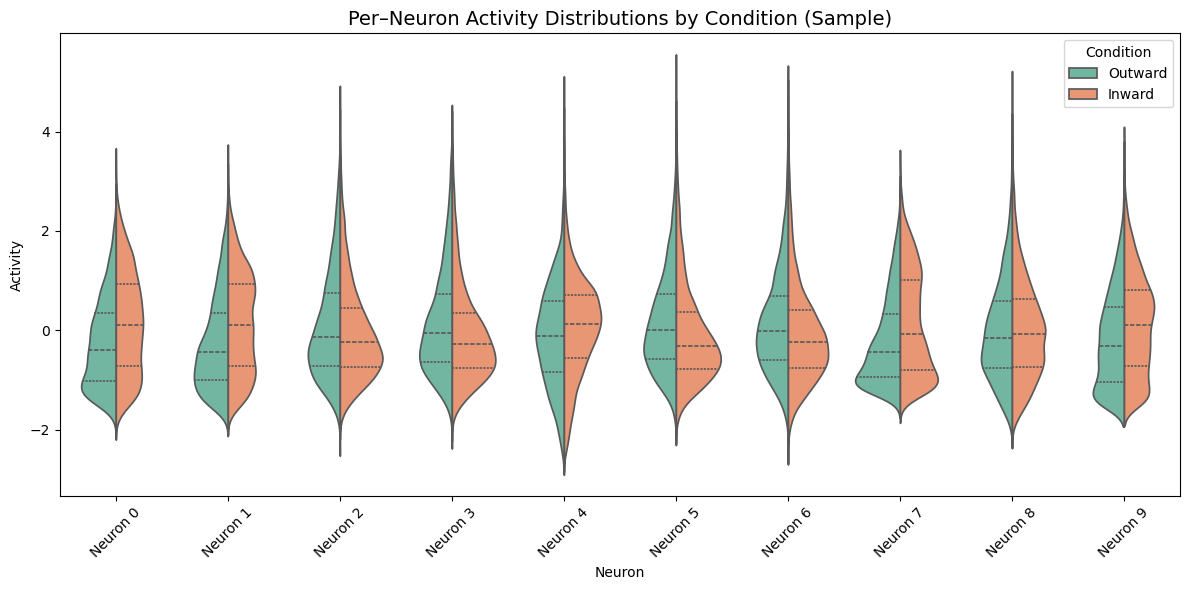

In [47]:
import pandas as pd
import seaborn as sns

data_list = []
for neuron in range(n_neurons):
    neuron_data = neuron_activity_normalized[neuron, :]
    for val in neuron_data[heading_neural_idx]:
        data_list.append({'Neuron': f'Neuron {neuron}', 'Condition': 'Outward', 'Activity': val})
    for val in neuron_data[inward_neural_idx]:
        data_list.append({'Neuron': f'Neuron {neuron}', 'Condition': 'Inward', 'Activity': val})

df_neuron = pd.DataFrame(data_list)

# If there are many neurons, you might filter to a subset for clarity:
subset_neurons = df_neuron[df_neuron['Neuron'].isin([f'Neuron {i}' for i in range(min(10, n_neurons))])]

plt.figure(figsize=(12, 6))
sns.violinplot(x='Neuron', y='Activity', hue='Condition', data=subset_neurons,
               split=True, inner='quartile', palette='Set2')
plt.title('Per–Neuron Activity Distributions by Condition (Sample)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


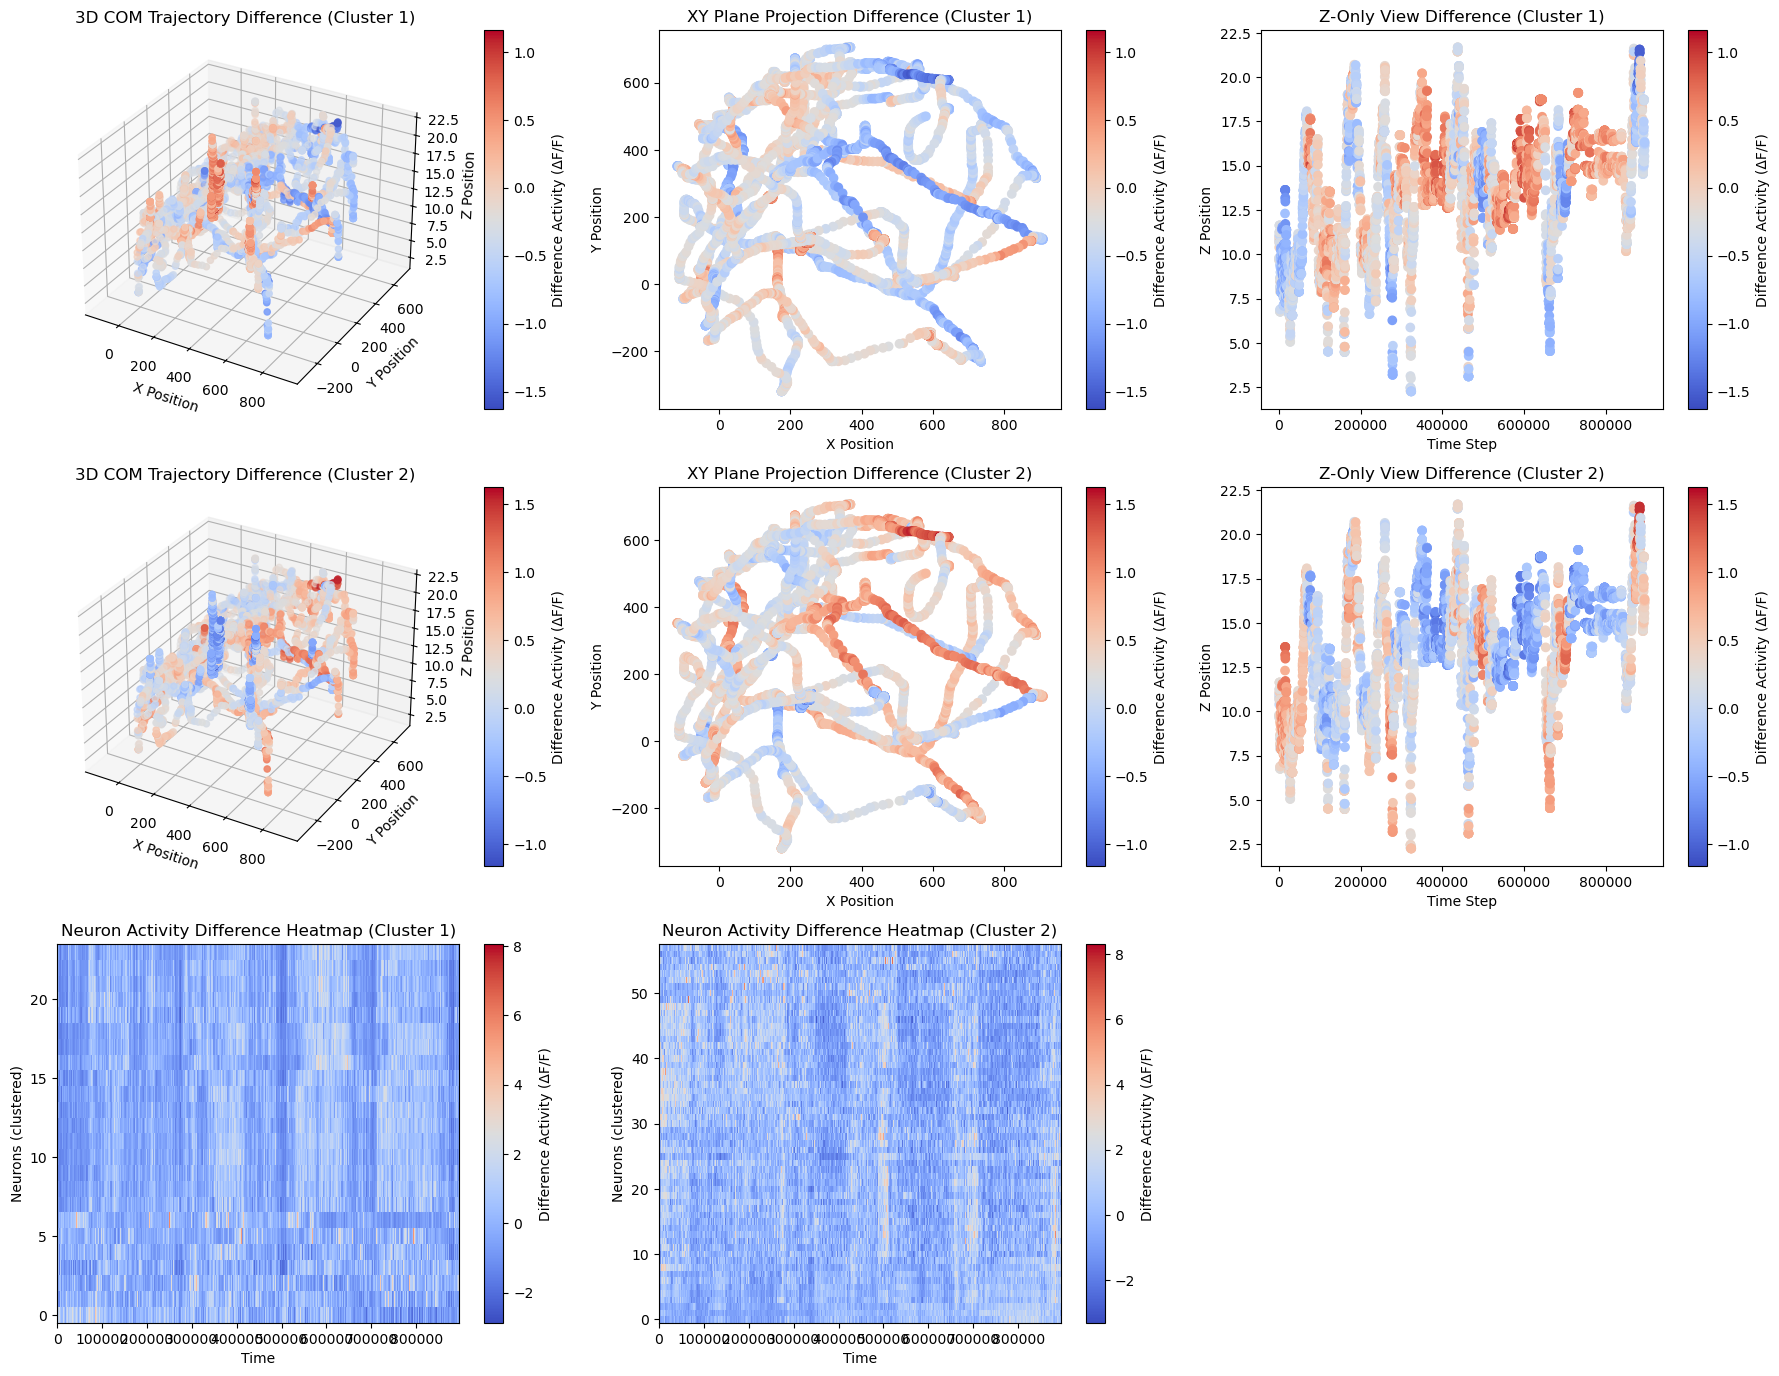

In [57]:
# Step 1: Compute the "shared" part (mean activity of both clusters)
shared_activity = (cluster_means[0, :] + cluster_means[1, :]) / 2

# Step 2: Subtract the shared part to get the "difference" for each cluster
difference_cluster_means = []
for cluster_id in range(num_clusters):
    difference = cluster_means[cluster_id, :] - shared_activity
    difference_cluster_means.append(difference)
difference_cluster_means = np.array(difference_cluster_means)

# Step 3: Recompute the neuron activity difference for heatmaps
difference_neuron_activity = []
for cluster_id in range(1, num_clusters + 1):
    cluster_neurons = neuron_activity_normalized[cluster_labels == cluster_id, :]
    cluster_difference = cluster_neurons - shared_activity[:cluster_neurons.shape[1]]
    difference_neuron_activity.append(cluster_difference)

# Step 4: Plot new graphs based on the "difference"

fig = plt.figure(figsize=(18, 18))

# Iterate over clusters for the COM plots
for cluster_id in range(num_clusters):
    row_offset = cluster_id * 3  # Offset for each cluster's row

    # 3D Scatter Plot (Difference)
    ax1 = fig.add_subplot(4, 3, row_offset + 1, projection='3d')
    scatter = ax1.scatter(
        df_new['com_x'], df_new['com_y'], df_new['com_z'],
        c=difference_cluster_means[cluster_id, :len(df_new['com_x'])],  # Cluster difference activity
        cmap='coolwarm', marker='o'
    )
    ax1.set_title(f'3D COM Trajectory Difference (Cluster {cluster_id + 1})')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_zlabel('Z Position')
    fig.colorbar(scatter, ax=ax1, pad=0.1, label='Difference Activity (ΔF/F)')

    # XY Plane Projection (Difference)
    ax2 = fig.add_subplot(4, 3, row_offset + 2)
    scatter_xy = ax2.scatter(
        df_new['com_x'], df_new['com_y'],
        c=difference_cluster_means[cluster_id, :len(df_new['com_x'])],  # Cluster difference activity
        cmap='coolwarm', marker='o'
    )
    ax2.set_title(f'XY Plane Projection Difference (Cluster {cluster_id + 1})')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    fig.colorbar(scatter_xy, ax=ax2, label='Difference Activity (ΔF/F)')

    # Z-Only View (Difference)
    ax3 = fig.add_subplot(4, 3, row_offset + 3)
    scatter_z = ax3.scatter(
        time, df_new['com_z'],
        c=difference_cluster_means[cluster_id, :len(df_new['com_z'])],  # Cluster difference activity
        cmap='coolwarm', marker='o'
    )
    ax3.set_title(f'Z-Only View Difference (Cluster {cluster_id + 1})')
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Z Position')
    fig.colorbar(scatter_z, ax=ax3, label='Difference Activity (ΔF/F)')

# Heatmaps for Cluster Differences
for cluster_id in range(num_clusters):
    cluster_diff = difference_neuron_activity[cluster_id]
    Z_cluster = linkage(cluster_diff, method='ward')
    neuron_order = leaves_list(Z_cluster)
    cluster_diff_ordered = cluster_diff[neuron_order, :]

    ax = fig.add_subplot(4, 3, 6 + cluster_id + 1)
    neuron_indices = np.arange(len(cluster_diff_ordered))
    time_values = time

    # Plot heatmap
    mesh = ax.pcolormesh(
        time_values, neuron_indices, cluster_diff_ordered,
        cmap='coolwarm', shading='auto'
    )
    ax.set_title(f'Neuron Activity Difference Heatmap (Cluster {cluster_id + 1})')
    ax.set_ylabel('Neurons (clustered)')
    ax.set_xlabel('Time')
    fig.colorbar(mesh, ax=ax, label='Difference Activity (ΔF/F)')

plt.tight_layout()
plt.show()


In [7]:

# Create a dictionary with cluster labels as keys and neuron names as values
clusters = {cluster: [] for cluster in np.unique(cluster_labels)}
for neuron, cluster in zip(filtered_neuron_columns, cluster_labels):
    clusters[cluster].append(neuron)

# Print neuron names for each cluster
for cluster, neurons in clusters.items():
    print(f"Cluster {cluster}: {neurons}")


Cluster 1: ['dF_F_roi1', 'dF_F_roi7', 'dF_F_roi9', 'dF_F_roi10', 'dF_F_roi11', 'dF_F_roi12', 'dF_F_roi14', 'dF_F_roi15', 'dF_F_roi16', 'dF_F_roi18', 'dF_F_roi20', 'dF_F_roi35', 'dF_F_roi54', 'dF_F_roi56', 'dF_F_roi57', 'dF_F_roi58', 'dF_F_roi59', 'dF_F_roi60', 'dF_F_roi61', 'dF_F_roi65', 'dF_F_roi74', 'dF_F_roi76', 'dF_F_roi78', 'dF_F_roi84']
Cluster 2: ['dF_F_roi0', 'dF_F_roi2', 'dF_F_roi3', 'dF_F_roi4', 'dF_F_roi5', 'dF_F_roi6', 'dF_F_roi8', 'dF_F_roi13', 'dF_F_roi17', 'dF_F_roi19', 'dF_F_roi21', 'dF_F_roi22', 'dF_F_roi23', 'dF_F_roi24', 'dF_F_roi25', 'dF_F_roi26', 'dF_F_roi27', 'dF_F_roi28', 'dF_F_roi30', 'dF_F_roi31', 'dF_F_roi32', 'dF_F_roi33', 'dF_F_roi34', 'dF_F_roi36', 'dF_F_roi37', 'dF_F_roi38', 'dF_F_roi39', 'dF_F_roi40', 'dF_F_roi41', 'dF_F_roi42', 'dF_F_roi43', 'dF_F_roi44', 'dF_F_roi45', 'dF_F_roi46', 'dF_F_roi47', 'dF_F_roi48', 'dF_F_roi49', 'dF_F_roi50', 'dF_F_roi51', 'dF_F_roi52', 'dF_F_roi53', 'dF_F_roi55', 'dF_F_roi62', 'dF_F_roi63', 'dF_F_roi66', 'dF_F_roi67', 'dF_F_

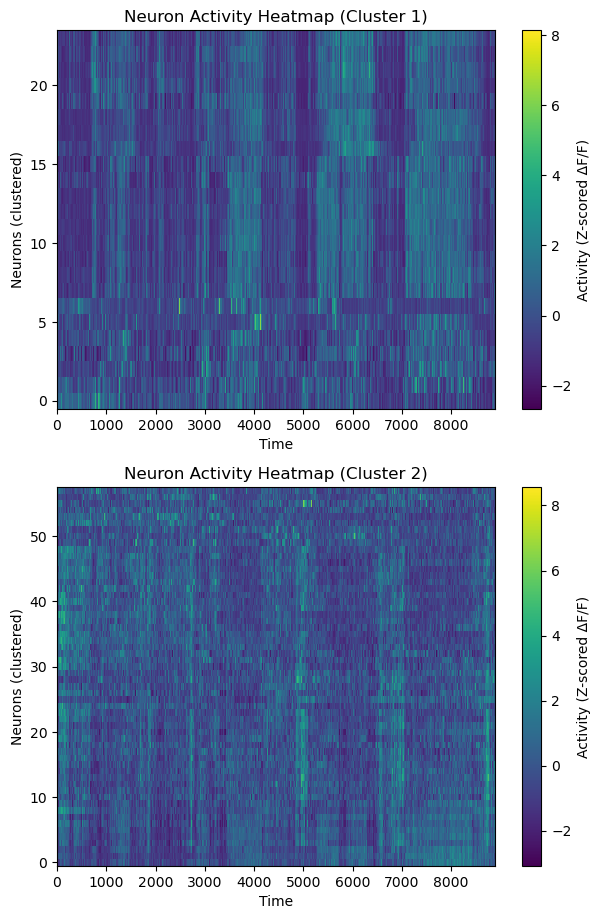

In [28]:
fig = plt.figure(figsize=(18, 18))

# Clustered Neuron Activity Heatmaps
for cluster_id in range(num_clusters):
    # Filter neuron activity for the current cluster
    cluster_neurons = neuron_activity_normalized[cluster_labels == cluster_id + 1, :]
    cluster_neuron_columns = [
        filtered_neuron_columns[i] for i in range(len(cluster_labels)) if cluster_labels[i] == cluster_id + 1
    ]

    # Hierarchical clustering for the current cluster
    Z_cluster = linkage(cluster_neurons, method='ward')
    neuron_order = leaves_list(Z_cluster)
    cluster_neurons_ordered = cluster_neurons[neuron_order, :]
    cluster_neuron_columns_ordered = [cluster_neuron_columns[i] for i in neuron_order]

    # Add a heatmap for the current cluster
    ax = fig.add_subplot(4, 3, 3 * cluster_id + 3)
    neuron_indices = np.arange(len(cluster_neurons_ordered))
    time_values = np.arange(cluster_neurons_ordered.shape[1])

    # Plot heatmap
    mesh = ax.pcolormesh(
        time_values, neuron_indices, cluster_neurons_ordered,
        cmap='viridis', shading='auto'
    )
    ax.set_title(f'Neuron Activity Heatmap (Cluster {cluster_id + 1})')
    ax.set_ylabel('Neurons (clustered)')
    ax.set_xlabel('Time')
    fig.colorbar(mesh, ax=ax, label='Activity (Z-scored ΔF/F)')

plt.tight_layout()
plt.show()


In [49]:
def main_plot_function(df_merged_with_dF_F, filtered_df, neuron_activity_normalized=None, filtered_neuron_columns=None):
    """
    Example main plotting function that:
      1) Plots COM (row 0)
      2) Plots left keypoints (row 1)
      3) Plots right keypoints (row 2)
      4) Plots the cluster timeline (row 3)
      5) Plots the Ca heatmap (rows 4-5)
    """
    df_new = df_merged_with_dF_F.copy()

    keypoint_indices = [1, 2, 3, 4]  # Corresponding to 'EarL', 'EarR', 'Snout', 'SpineF'
    keypoint_labels = {1: "EarL", 2: "EarR", 3: "Snout", 4: "SpineF"}
    
    # Example location indices and labels
    location_indices_left = [3, 4, 12, 11, 10, 9]
    location_labels_left = {3: "Snot", 4: "spineF", 12: "shoulderL", 11: "elbowL", 10: "wristL", 9: "forepawL"}

    location_indices_right = [3, 4, 16, 15, 14, 13]
    location_labels_right = {3: "Snot", 4: "spineF", 16: "shoulderR", 15: "elbowR", 14: "wristR", 13: "forepawR"}

    
    # Assume time is the index
    # time = df_new["timestamp_ms_mini"]
    
    # --- Figure & GridSpec ---
    fig = plt.figure(figsize=(15, 18))
    gs = fig.add_gridspec(nrows=6, ncols=1, height_ratios=[2, 1.5, 1.5, 1, 1, 3])
    # That gives us:
    #  row 0 => ax1 for COM
    #  row 1 => ax2 for Left Keypoints
    #  row 2 => ax3 for Right Keypoints
    #  row 3 => ax4 for cluster timeline
    #  row 4-5 => ax5 for Ca heatmap


    ###########################################
    # Plot 1 (row 0): Ca²⁺ Heatmap
    ###########################################
    ax1 = fig.add_subplot(gs[0, 0])
    if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
        # Hierarchical clustering
        Z = linkage(neuron_activity_normalized, method='ward')
        neuron_order = leaves_list(Z)  # Leaves from dendrogram
        neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
        ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

        # Plot heatmap with pcolormesh
        neuron_indices = np.arange(len(neuron_activity_ordered))
        mesh = ax1.pcolormesh(
            time, neuron_indices, neuron_activity_ordered,
            cmap='viridis', shading='auto'
        )
        ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
        ax1.set_ylabel('Neurons (clustered)')
    else:
        print("Neuron activity data not found. Skipping heatmap plot.")
        ax1.text(0.5, 0.5, 'No neuron activity data available.',
                transform=ax1.transAxes, ha='center', va='center')
        ax1.set_title('No Neuron Activity Plot')
    ax1.tick_params(labelbottom=False)
    ###########################################
    # Top Plot (row 0): COM trajectories
    ###########################################
    # ax1 = fig.add_subplot(gs[0, 0])
    # if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
    #     ax1.plot(time, df_new['com_x'], color='red', label='COM X')
    #     ax1.plot(time, df_new['com_y'], color='green', label='COM Y')
    #     ax1.plot(time, df_new['com_z'], color='blue', label='COM Z')
    #     ax1.set_ylabel('COM (mm)')
    #     ax1.set_title('Center of Mass Trajectories')
    #     ax1.legend(loc='upper left')
    # else:
    #     print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
    # ax1.tick_params(labelbottom=False)  # Remove x-axis labels

    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

    if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
        ax2.plot(time, df_new['com_x'], color='red', label='COM X')
        ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
        ax2.set_ylabel('COM (mm)')
        ax2.set_title('Center of Mass Trajectories')
        
        # Create a secondary y-axis for COM Z
        ax2_right = ax2.twinx()
        ax2_right.plot(time, df_new['com_z'], color='blue', label='COM Z')
        ax2_right.set_ylabel('COM Z (mm)', color='blue')
        ax2_right.tick_params(axis='y', labelcolor='blue')
        
        # Combine legends from both axes
        lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
        lines_ax2_right, labels_ax2_right = ax2_right.get_legend_handles_labels()
        ax2.legend(lines_ax2 + lines_ax2_right, labels_ax2 + labels_ax2_right, loc='lower right')
    else:
        print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")

    ax2.tick_params(labelbottom=False)


    ###########################################
    # Plot: Left Side Keypoints (Z-dimension, Egocentric)
    ###########################################
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
    ax3.set_title('Left Side Keypoints (Z-dimension, Egocentric)')
    if 'com_z' in df_new.columns:
        for idx in location_indices_left:
            z_col = f'kp{idx}_z'
            if z_col in df_new.columns:
                z_ego = df_new[z_col] - df_new['com_z']
                ax3.plot(time, z_ego, label=location_labels_left[idx])
            else:
                print(f"Warning: {z_col} not found for idx={idx}")
        ax3.set_ylabel('Relative Pos Z (mm)')
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        print("No COM Z found. Cannot compute egocentric coordinates.")
    ax3.tick_params(labelbottom=False)

    # ax3.set_xlabel('Time (ms)')

    ###########################################
    # Fourth Plot: Z-dimension Egocentric
    ###########################################
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax4.set_title('Specific Keypoints (Z-dimension, Egocentric)')
    if 'com_z' in df_new.columns:
        for idx in keypoint_indices:
            z_col = f'kp{idx}_z'
            if z_col in df_new.columns:
                z_ego = df_new[z_col] - df_new['com_z']
                ax4.plot(time, z_ego, label=keypoint_labels[idx])
            else:
                print(f"Warning: {z_col} not found for idx={idx}")
        ax4.set_ylabel('Relative Pos Z (mm)')
        ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        print("No COM Z found. Cannot compute egocentric coordinates.")
    ax4.tick_params(labelbottom=True)

    ax4.set_xlabel('Time (ms)')


main_plot_function(df_merged_with_dF_F, filtered_df,
                   neuron_activity_normalized=neuron_activity_normalized,
                   filtered_neuron_columns=filtered_neuron_columns)


NameError: name 'neuron_activity_reshaped' is not defined

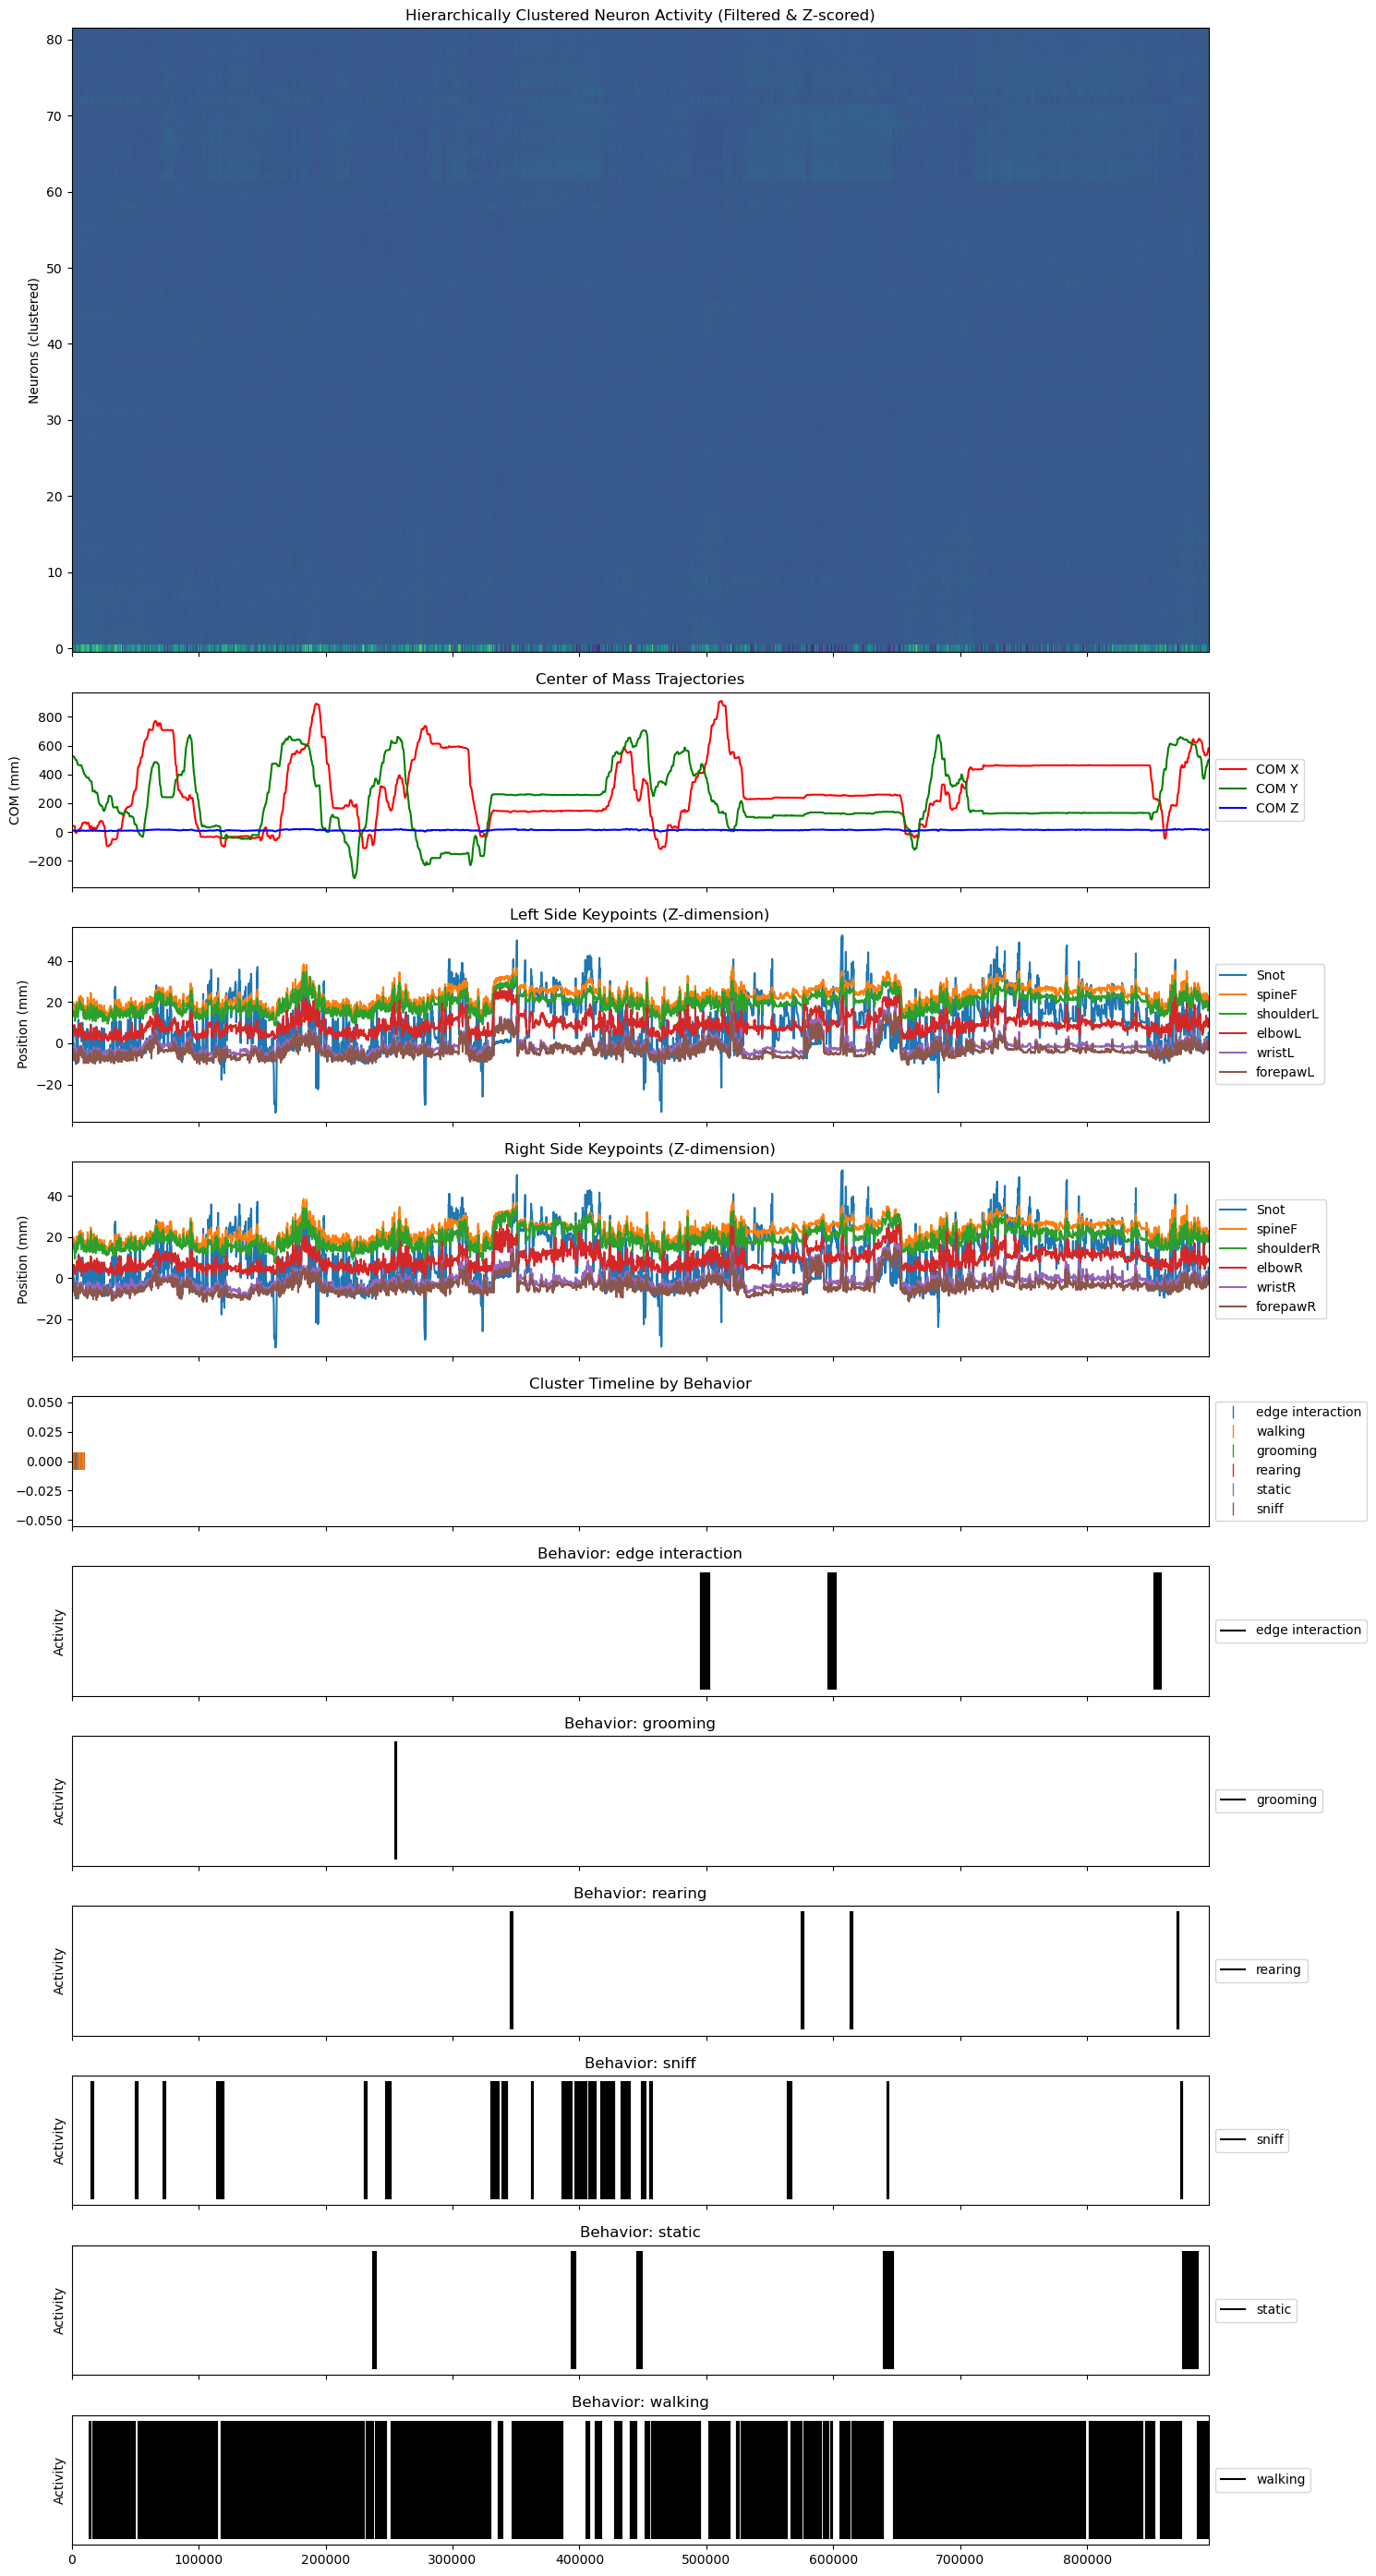

In [66]:
def main_plot_function(df_merged_with_dF_F, filtered_df, neuron_activity_normalized=None, filtered_neuron_columns=None):
    """
    Example main plotting function that:
      1) Plots the Ca heatmap (rows 0-1)
      2) Plots COM (row 2)
      3) Plots left keypoints (row 3)
      4) Plots right keypoints (row 4)
      5) Plots the cluster timeline (row 5)
      6) Plots individual behavior timelines (rows 6+)
    """
    df_new = df_merged_with_dF_F

    # Example location indices and labels
    location_indices_left = [3, 4, 12, 11, 10, 9]
    location_labels_left = {3: "Snot", 4: "spineF", 12: "shoulderL", 11: "elbowL", 10: "wristL", 9: "forepawL"}

    location_indices_right = [3, 4, 16, 15, 14, 13]
    location_labels_right = {3: "Snot", 4: "spineF", 16: "shoulderR", 15: "elbowR", 14: "wristR", 13: "forepawR"}

    # Assume time is the index
    time = df_new["timestamp_ms_mini"]

    # --- Figure & GridSpec ---
    unique_behaviors = sorted(set(behavior_labels.values()))
    num_behaviors = len(unique_behaviors)
    fig = plt.figure(figsize=(15, 22 + num_behaviors))  # Adjust height based on behaviors
    gs = fig.add_gridspec(nrows=6 + num_behaviors, ncols=1, height_ratios=[3, 1.5, 1.5, 1.5, 1.5, 1] + [1] * num_behaviors)

    ###########################################
    # Top Plot (rows 0-1): Ca heatmap
    ###########################################
    ax1 = fig.add_subplot(gs[0:2, 0])
    if neuron_activity_normalized is not None and filtered_neuron_columns is not None:
        # Hierarchical clustering
        Z = linkage(neuron_activity_normalized, method='ward')
        neuron_order = leaves_list(Z)  # Leaves from dendrogram
        neuron_activity_ordered = neuron_activity_normalized[neuron_order, :]
        ordered_neuron_columns = [filtered_neuron_columns[i] for i in neuron_order]

        # Plot heatmap with pcolormesh
        neuron_indices = np.arange(len(neuron_activity_ordered))
        mesh = ax1.pcolormesh(
            time, neuron_indices, neuron_activity_ordered,
            cmap='viridis', shading='auto'
        )
        ax1.set_title('Hierarchically Clustered Neuron Activity (Filtered & Z-scored)')
        ax1.set_ylabel('Neurons (clustered)')
    else:
        print("Neuron activity data not found. Skipping heatmap plot.")
        ax1.text(0.5, 0.5, 'No neuron activity data available.',
                 transform=ax1.transAxes, ha='center', va='center')
        ax1.set_title('No Neuron Activity Plot')
    ax1.tick_params(labelbottom=False)

    ###########################################
    # Second Plot (row 2): COM trajectories
    ###########################################
    ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)
    if {'com_x', 'com_y', 'com_z'}.issubset(df_new.columns):
        ax2.plot(time, df_new['com_x'], color='red', label='COM X')
        ax2.plot(time, df_new['com_y'], color='green', label='COM Y')
        ax2.plot(time, df_new['com_z'], color='blue', label='COM Z')
        ax2.set_ylabel('COM (mm)')
        ax2.set_title('Center of Mass Trajectories')
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside
    else:
        print("COM columns not found (com_x, com_y, com_z). Check your DataFrame.")
    ax2.tick_params(labelbottom=False)

    ###########################################
    # Third Plot (row 3): Left Side Keypoints (Z-dim)
    ###########################################
    ax3 = fig.add_subplot(gs[3, 0], sharex=ax1)
    ax3.set_title('Left Side Keypoints (Z-dimension)')
    for idx in location_indices_left:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            ax3.plot(time, df_new[z_col], label=location_labels_left[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax3.set_ylabel('Position (mm)')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside
    ax3.tick_params(labelbottom=False)

    ###########################################
    # Fourth Plot (row 4): Right Side Keypoints (Z-dim)
    ###########################################
    ax4 = fig.add_subplot(gs[4, 0], sharex=ax1)
    ax4.set_title('Right Side Keypoints (Z-dimension)')
    for idx in location_indices_right:
        z_col = f'kp{idx}_z'
        if z_col in df_new.columns:
            ax4.plot(time, df_new[z_col], label=location_labels_right[idx])
        else:
            print(f"Warning: {z_col} not found for idx={idx}")
    ax4.set_ylabel('Position (mm)')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside
    ax4.tick_params(labelbottom=False)

    ###########################################
    # Fifth Plot (row 5): Cluster Timeline
    ###########################################
    ax5 = fig.add_subplot(gs[5, 0], sharex=ax1)
    plot_cluster_timeline_on_axes(
        ax5, 
        filtered_df, 
        time_index=df_new.index, 
        behavior_labels=behavior_labels, 
        # xlim=ax1.get_xlim()  # Match x-axis limits with ax1
    )
    ax5.tick_params(labelbottom=False)
    # ax5.set_yticks([])
    # ax5.set_ylabel("") 
    # ax5.set_xticks([])
    # ax5.set_xlabel("")

    ###########################################
    # Behavior Plots (rows 6+): Individual timelines
    ###########################################
    for i, behavior in enumerate(unique_behaviors):
        ax = fig.add_subplot(gs[6 + i, 0], sharex=ax1)
        plot_behavior_clusters(ax, filtered_df, behavior_name=behavior, behavior_labels=behavior_labels, time_index=time)
        ax.set_title(f'Behavior: {behavior}')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside
        if i < num_behaviors - 1:
            ax.tick_params(labelbottom=False)  # Remove x-axis labels except for the last plot

    plt.tight_layout()
    plt.show()


# Example call:
main_plot_function(df_new, filtered_df,
                   neuron_activity_normalized=neuron_activity_filtered,#neuron_activity_normalized,
                   filtered_neuron_columns=filtered_neuron_columns)


In [60]:
neuron_activity_filtered

array([[ 0.68018412,  0.46013887,  0.09795208, ...,  2.24510243,
         2.14599633,  2.08977805],
       [ 0.53150099,  0.24834143, -0.12867393, ...,  1.14788363,
         0.73656152,  0.9903199 ],
       [ 1.43984865,  0.99674829,  0.79202917, ...,  1.96889348,
         1.48160465,  2.16319165],
       ...,
       [ 2.11676329,  2.2632056 ,  1.66321303, ...,  0.21441226,
         0.37050503,  0.92465091],
       [ 4.09386386,  3.35445048,  1.88430973, ..., -0.75743313,
        -0.30984025, -0.62169728],
       [-0.07793307, -0.02764664,  0.06368916, ...,  1.0446645 ,
         1.63043396,  1.10700454]])